<AxesSubplot: xlabel='Date'>

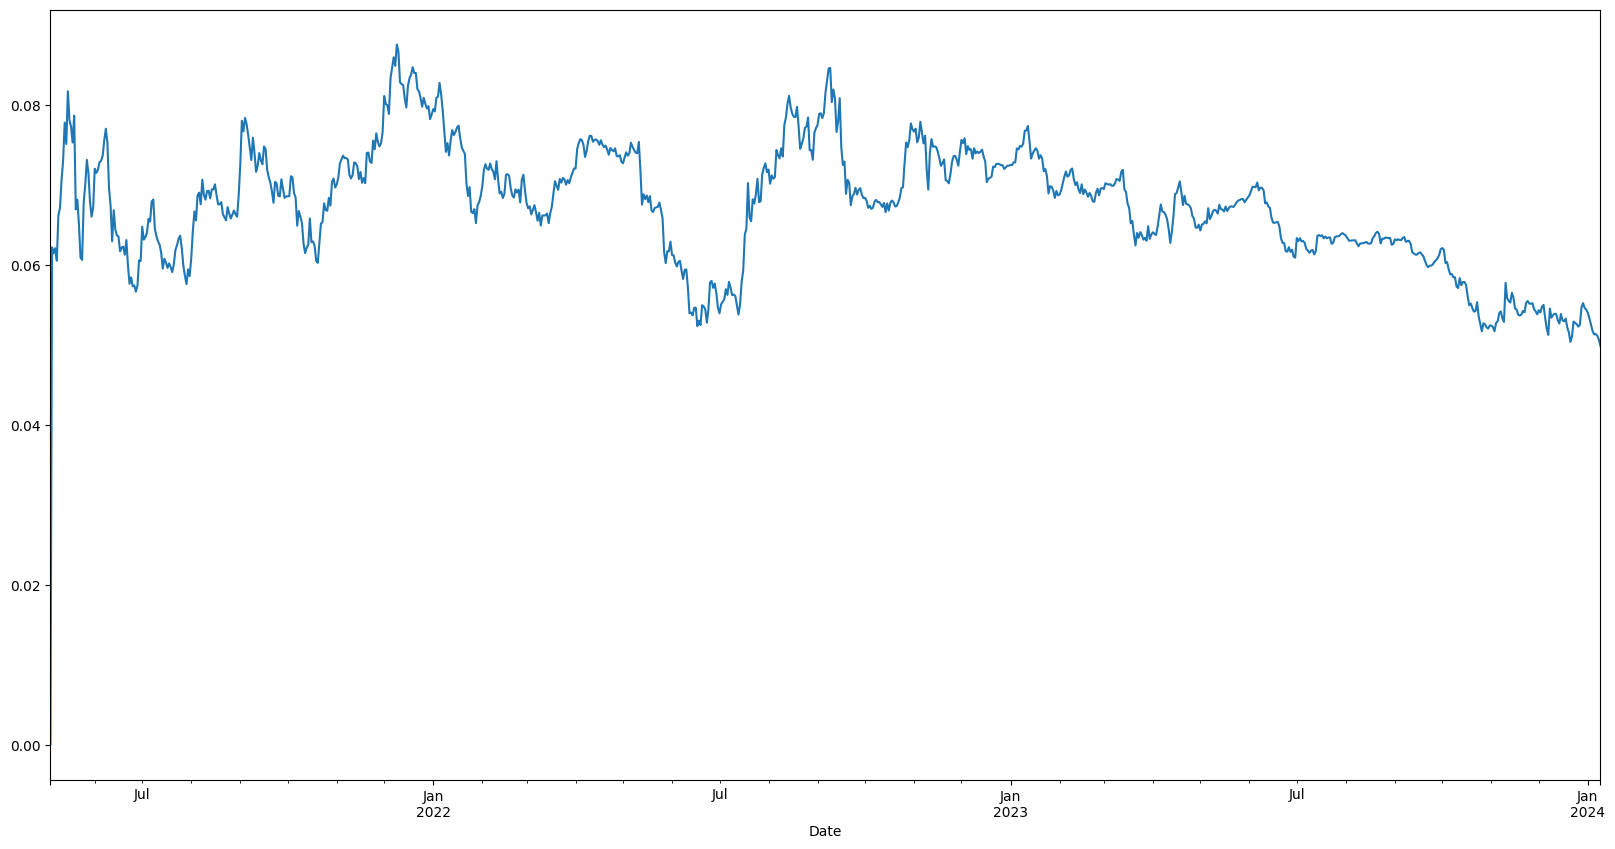

In [126]:

import ast
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   
from sklearn import metrics 
import defi.defi_tools as dft
import math 
import random
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import tools


df = pd.read_csv('../data/pools_daily_weth_btc.csv', delimiter=';', parse_dates=['Date'], index_col='Date').sort_index(ascending=True)
#df['Close (WBTC)'].plot(figsize=(20,10))
data = df[['Close (WBTC)']]
#data = df.loc['2021-05-06':][['Close (USDC)']]
#data, data_test = data[:760], data[760:]
df_day = data.resample('D').mean()
#data_test = data_test.resample('D').mean()

# Replace missing value
df_day.fillna(method = "ffill", inplace = True)
#data_test.fillna(method = "ffill", inplace = True)

# Confirm changes
df_day[df_day.isnull().any(axis = 1)]

df_day['Close (WBTC)'].plot(figsize=(20,10))

<AxesSubplot: xlabel='Date'>

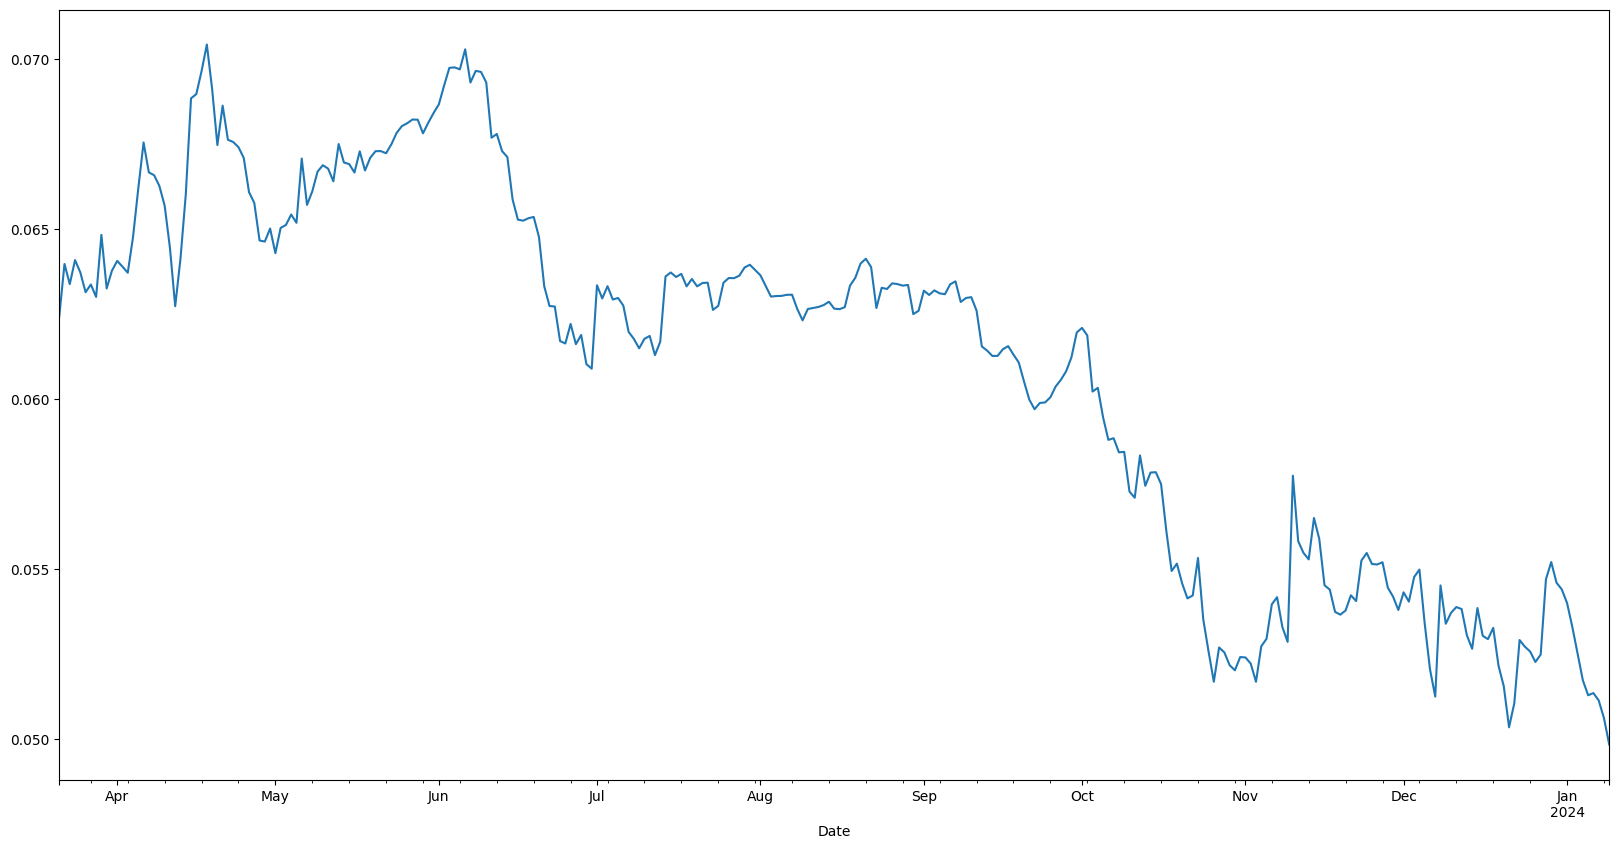

In [127]:
df_day.iloc[int(len(df_day) * 0.7):]['Close (WBTC)'].plot(figsize=(20,10))

Dickey–Fuller test: p=0.000000


<Figure size 2000x700 with 0 Axes>

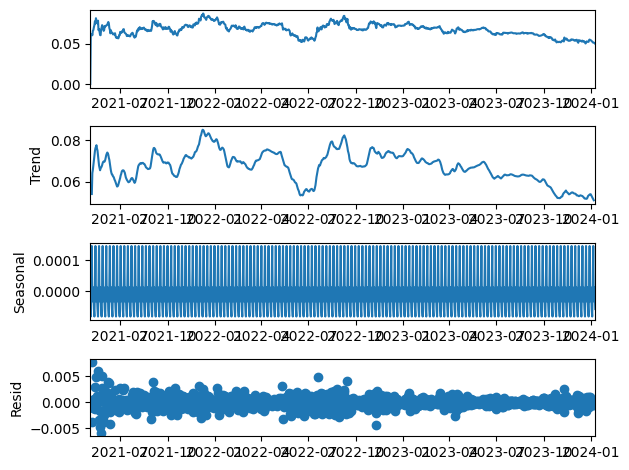

In [128]:
# Stationarity check and STL-decomposition of the series
plt.figure(figsize=[20,7])
sm.tsa.seasonal_decompose(df_day).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day)[1]) # Looks like its stationary

In [129]:
# Stationarity check and STL-decomposition of the series for log returns
#df_returns = df_day['Close (WBTC)'].pct_change() + 1
#df_returns = df_returns.ffill().dropna()
#df_returns = df_returns.dropna()
#df_returns['Log Returns'] = np.log(df_returns)

#df_returns = pd.DataFrame(df_returns['Log Returns'])
#plt.figure(figsize=[20,7])
#sm.tsa.seasonal_decompose(df_returns).plot()
#print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_returns)[1])

In [174]:

# Train and test sets
df_returns = df_day['Close (WBTC)']
df_returns, test_returns = df_returns.iloc[:int(df_returns.shape[0]*0.7)], df_returns.iloc[int(df_returns.shape[0]*0.7):]
df_returns.to_csv('../data/df_returns.csv')
test_returns.to_csv('../data/test_returns.csv')


ADF Statistic: -3.098967524285362, p-value: 0.026629690721406196


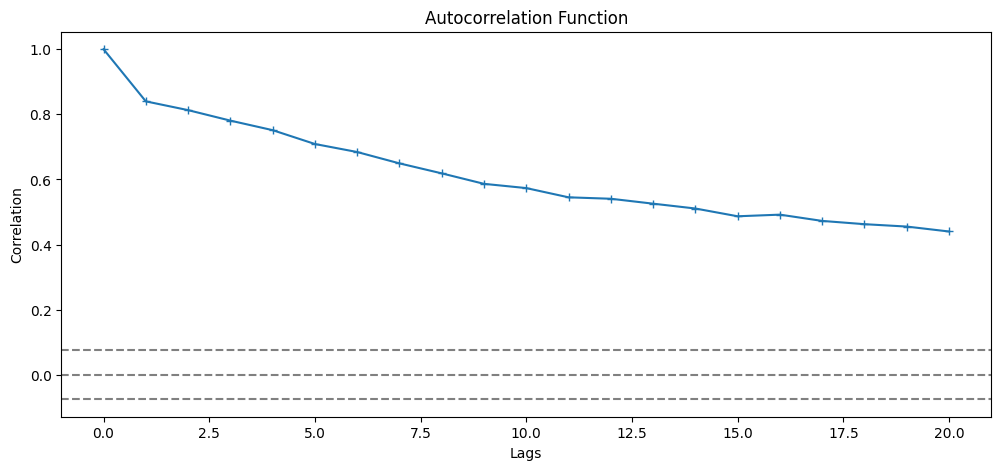

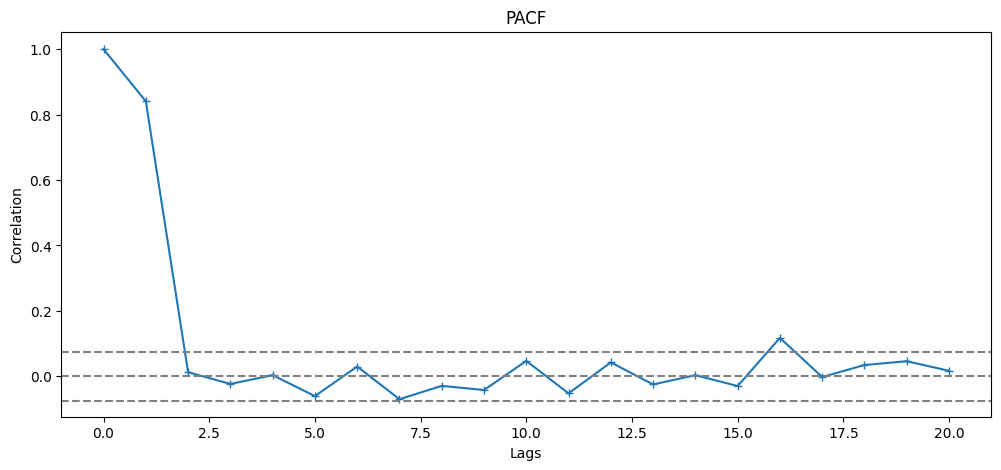

In [131]:
# Using Log Returns, check for stationarity
result = adfuller(df_returns)
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')



# Checking for ARIMA parameters
acf_values = acf(df_returns, nlags=20)
pacf_values = pacf(df_returns, nlags=20, method='ols')

# Plot the ACF and PACF
plt.figure(figsize=(12,5))
plt.plot(acf_values, label='ACF', marker="+")
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_returns)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_returns)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pacf_values, label='PACF', marker="+")
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_returns)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_returns)), linestyle='--', color='gray')
plt.title('PACF')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()


# ADF seems to indicate 4 - 6
# PACF seems to indicate 4- 8


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           Close (WBTC)   No. Observations:                  686
Model:                 ARIMA(4, 4, 0)   Log Likelihood                2813.326
Date:                Tue, 09 Jan 2024   AIC                          -5616.652
Time:                        16:18:05   BIC                          -5594.027
Sample:                    05-04-2021   HQIC                         -5607.896
                         - 03-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6957      0.019    -90.791      0.000      -1.732      -1.659
ar.L2         -1.5840      0.028    -57.443      0.000      -1.638      -1.530
ar.L3         -0.9040      0.026    -34.949      0.0

C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


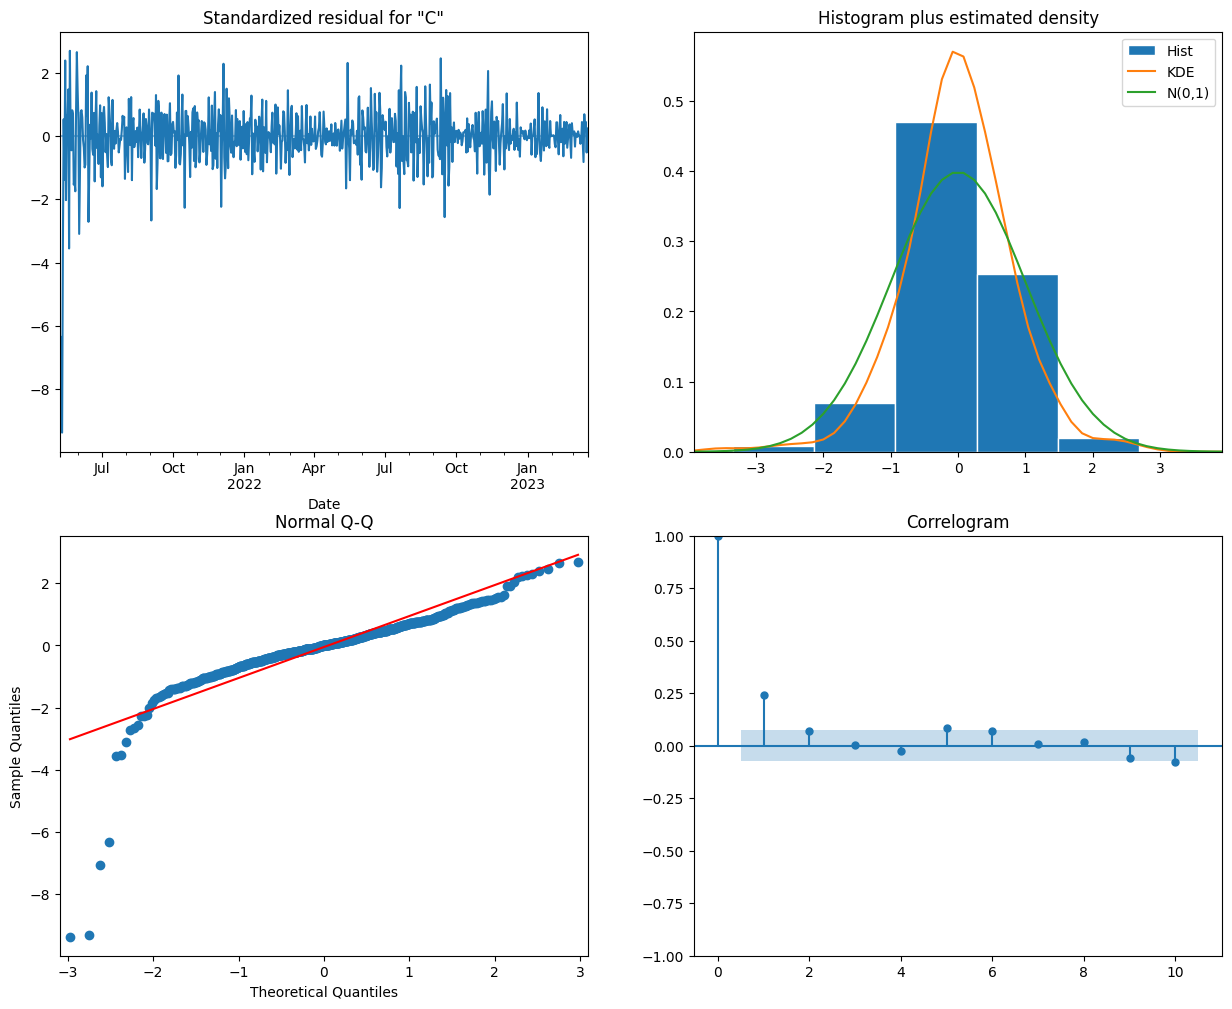

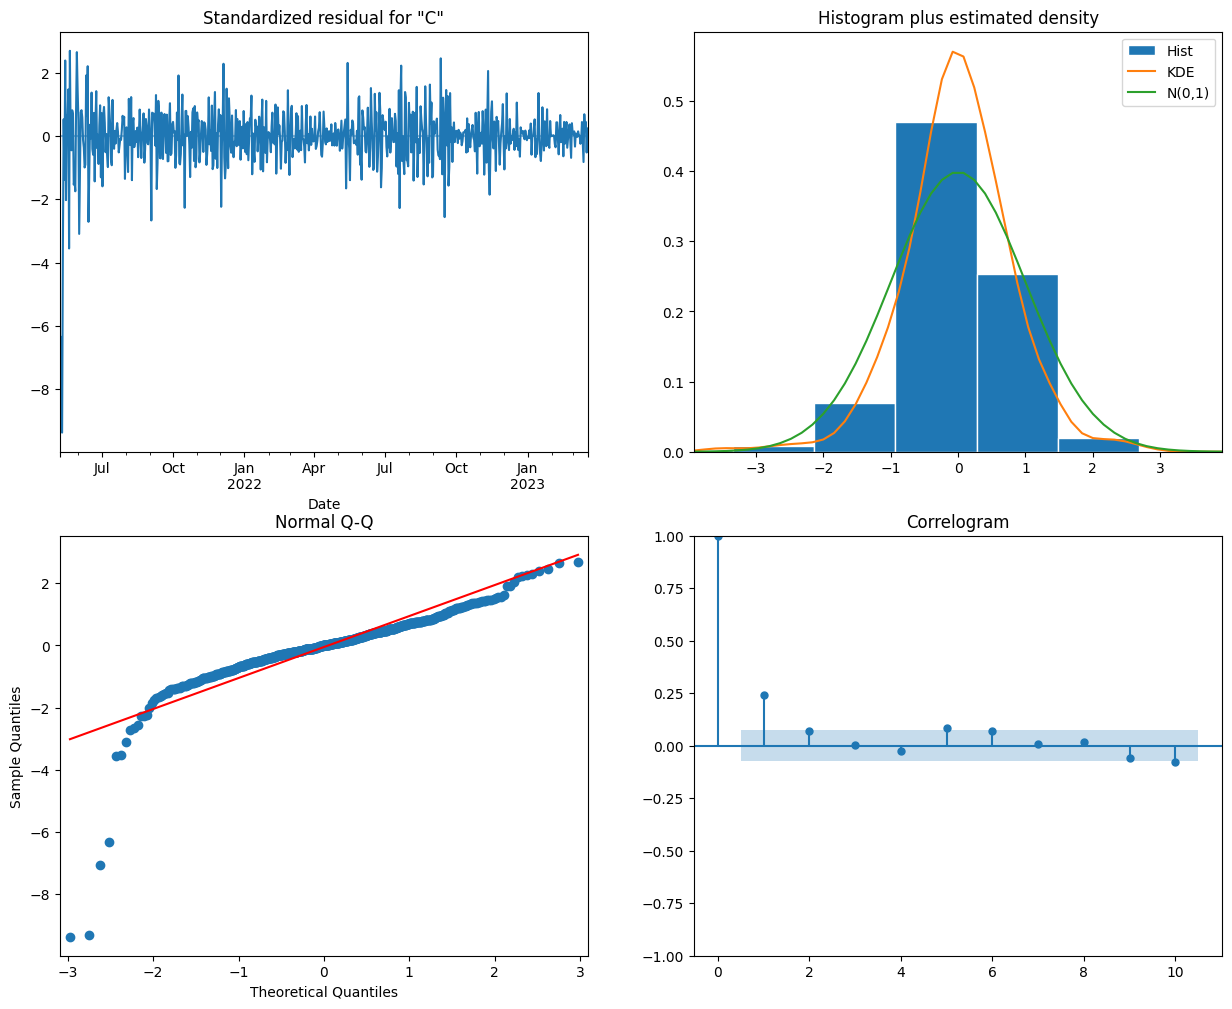

In [132]:
# ARIMA Model
model = ARIMA(df_returns, order=(4, 4, 0))
print(model.fit().summary())
model_fit = model.fit()
model_fit.plot_diagnostics(figsize=(15,12))


                               SARIMAX Results                                
Dep. Variable:           Close (WBTC)   No. Observations:                  686
Model:                 ARIMA(9, 0, 2)   Log Likelihood                3048.409
Date:                Tue, 09 Jan 2024   AIC                          -6070.819
Time:                        16:18:09   BIC                          -6011.917
Sample:                    05-04-2021   HQIC                         -6048.029
                         - 03-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0680      0.003     20.005      0.000       0.061       0.075
ar.L1          0.5948      0.219      2.720      0.007       0.166       1.023
ar.L2          0.2067      0.199      1.041      0.2

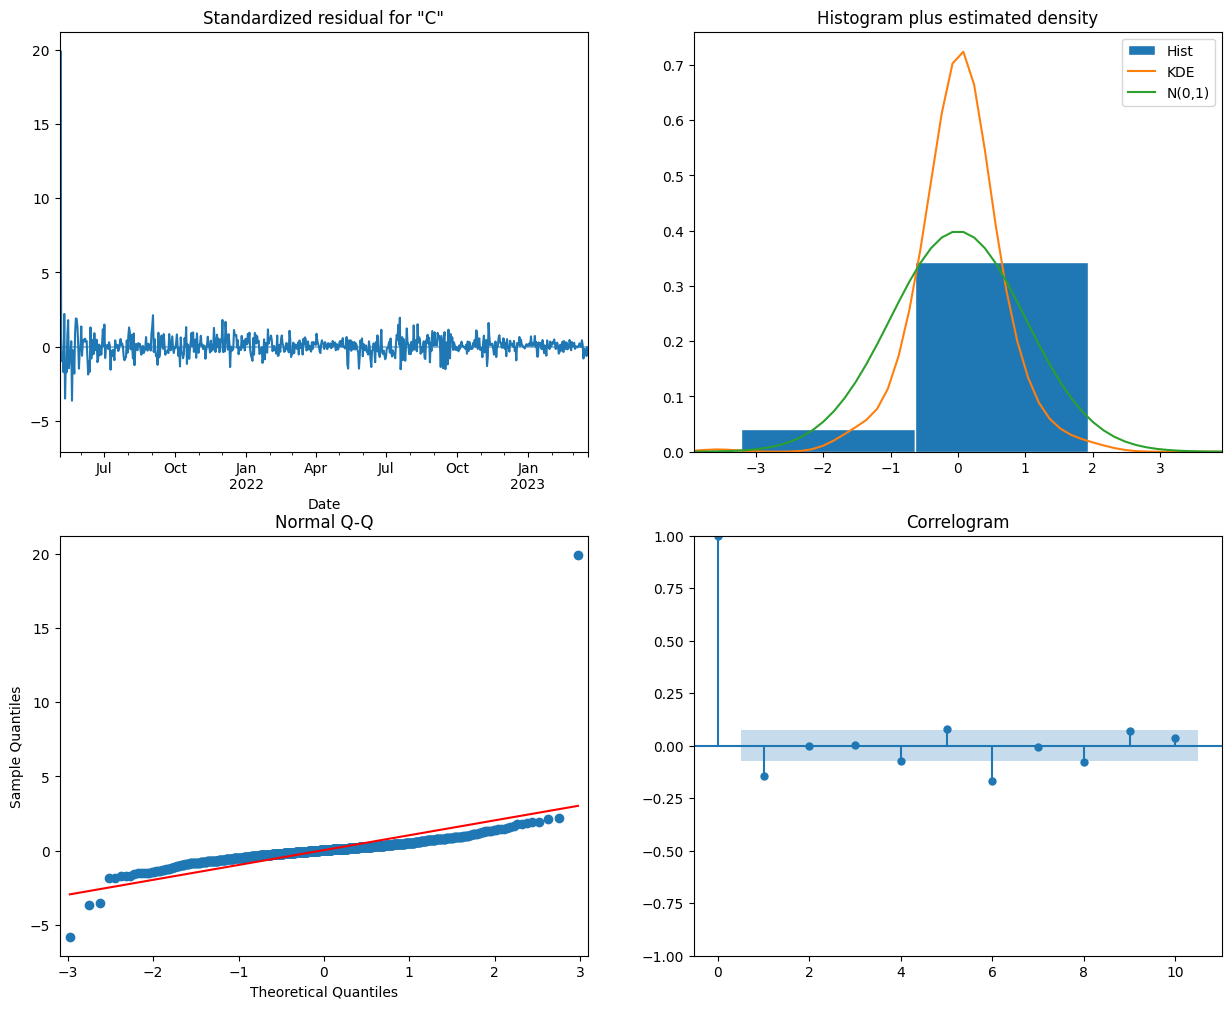

In [133]:
# Grid-Search Optimization
def grid_search_arima(df_returns):
    aic_values = []
    bic_values = []
    hqic_values = []
    p_values = []
    q_values = []
    d_values = []
    log_likelihoods = []
    
    for p in range(10):
        for q in range(10):
            for d in range(10):
                print(f'p={p}, d={d}, q={q}')
                try:
                    model = ARIMA(df_returns, order=(p, d, q))
                    model_fit = model.fit()
                    aic_values.append(model_fit.aic)
                    bic_values.append(model_fit.bic)
                    hqic_values.append(model_fit.hqic)
                    p_values.append(p)
                    q_values.append(q)
                    d_values.append(d)
                    log_likelihoods.append(model_fit.llf)
                except:
                    continue
    return aic_values, bic_values, hqic_values, p_values, q_values, d_values, log_likelihoods

#aic_values, bic_values, hqic_values, p_values, q_values, d_values, log_likelihoods = grid_search_arima(df_returns)
          
# Print the aic, bic, hqic values for the best ARIMA model
#result = pd.DataFrame({'aic':aic_values, 'bic':bic_values, 'hqic':hqic_values, 
#                       'p':p_values, 'q':q_values, 'd':d_values, 'llf': log_likelihoods}).sort_values('aic').reset_index(drop=True)

# Get out minimized values
#p_value, q_value, d_value = result.iloc[0]['p'], result.iloc[0]['q'], result.iloc[0]['d']
p_value, q_value, d_value = 9, 2, 0
model = ARIMA(df_returns, order=(p_value, d_value, q_value))
model_fit = model.fit()
print(model_fit.summary())
print(model_fit.plot_diagnostics(figsize=(15, 12)))

                               SARIMAX Results                                
Dep. Variable:           Close (WBTC)   No. Observations:                  686
Model:                 ARIMA(9, 0, 2)   Log Likelihood                3048.409
Date:                Tue, 09 Jan 2024   AIC                          -6070.819
Time:                        16:18:12   BIC                          -6011.917
Sample:                    05-04-2021   HQIC                         -6048.029
                         - 03-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0680      0.003     20.005      0.000       0.061       0.075
ar.L1          0.5948      0.219      2.720      0.007       0.166       1.023
ar.L2          0.2067      0.199      1.041      0.2

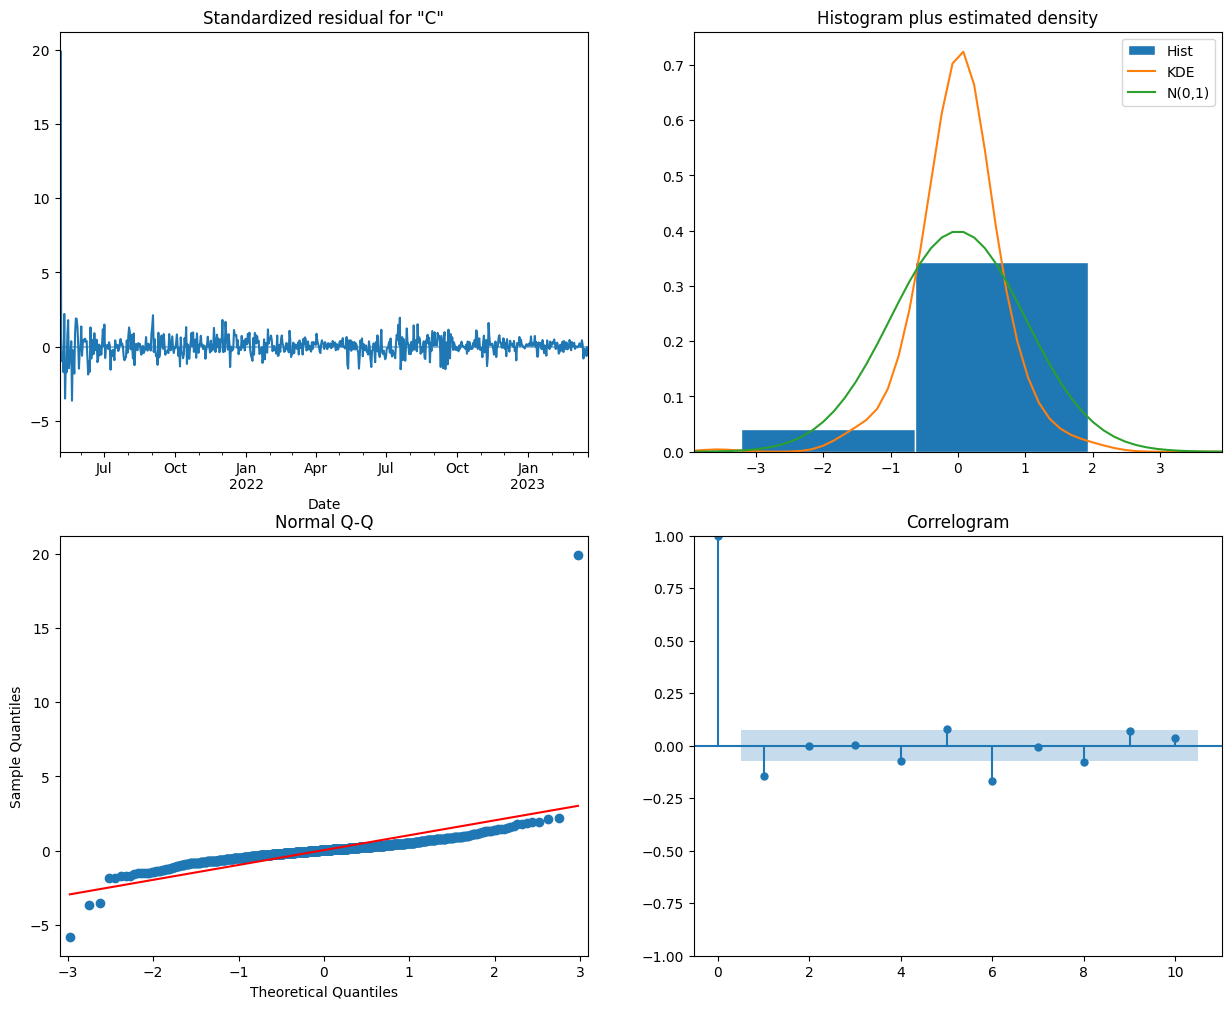

In [134]:

# Upon further inspection, the best model is ARIMA(2, 0, 2)

# Best ARIMA model IS ARIMA(5, 0, 9)
model = ARIMA(df_returns, order=(p_value, d_value, q_value))
model_fit = model.fit()
print(model_fit.summary())
print(model_fit.plot_diagnostics(figsize=(15, 12)))

AIC: -6070.8186939749985
BIC: -6011.917284814562
HQIC: -6048.02861930132
Residuals: count    686.000000
mean       0.000047
std        0.003877
min       -0.068048
25%       -0.000811
50%        0.000101
75%        0.000956
max        0.059922
dtype: float64
Correlation: -0.515365617192052


Text(0, 0.5, 'Correlation')

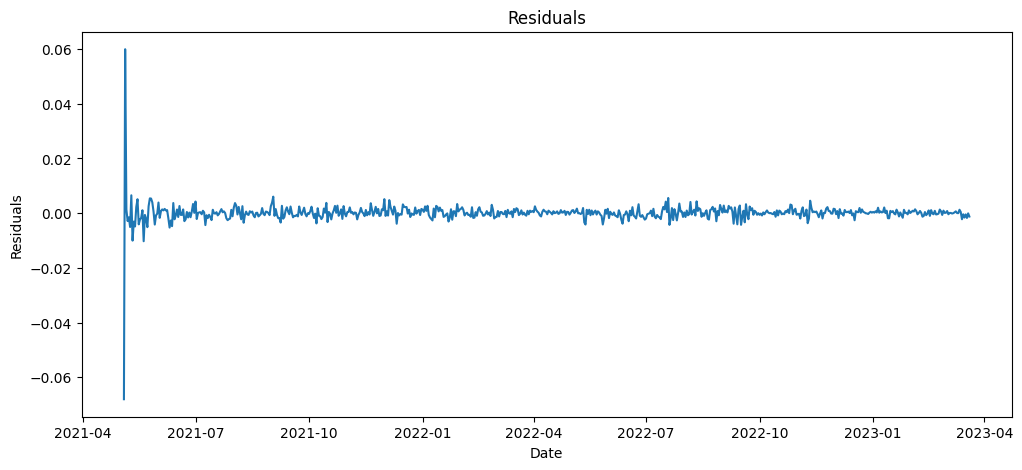

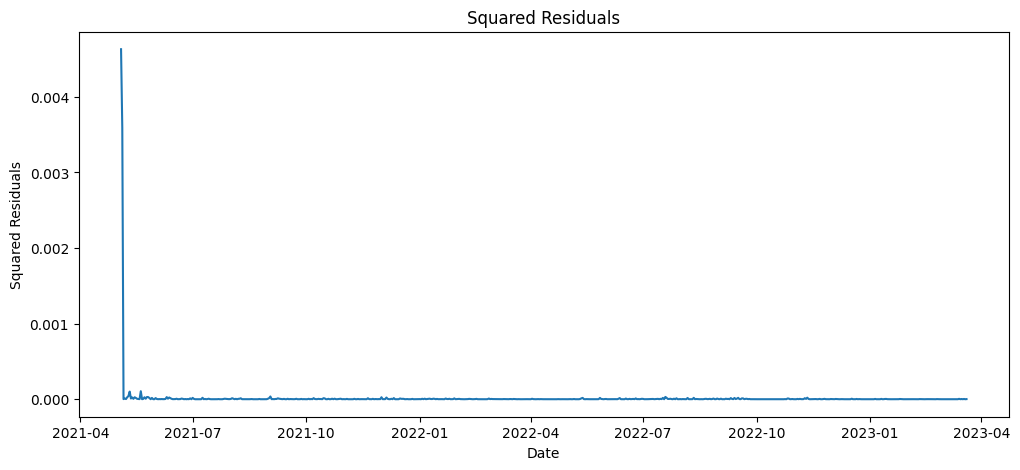

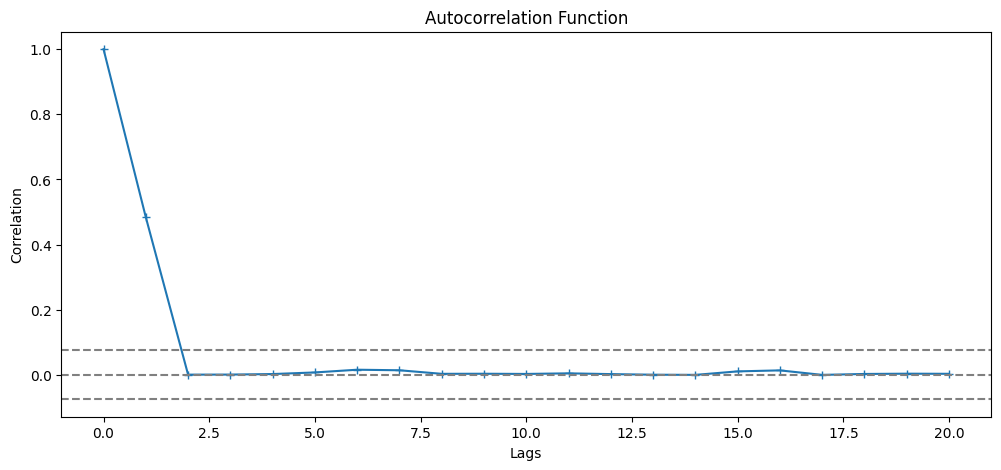

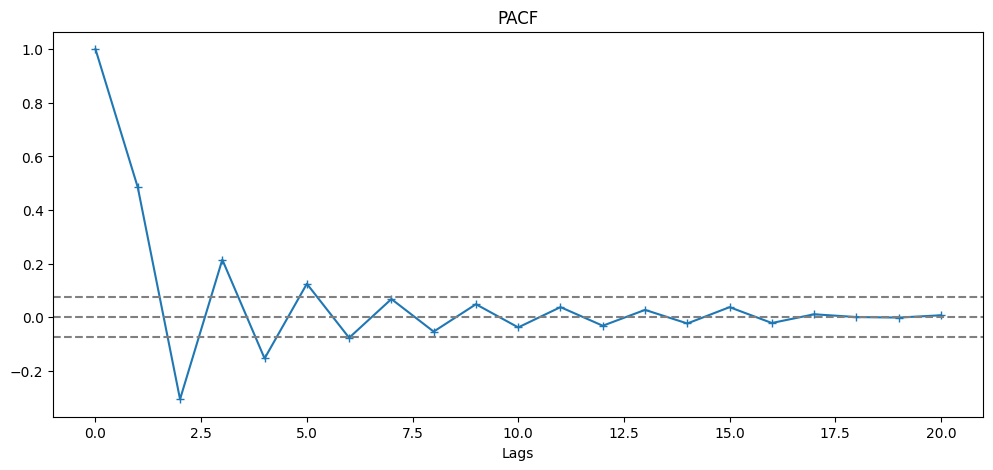

<Figure size 1200x500 with 0 Axes>

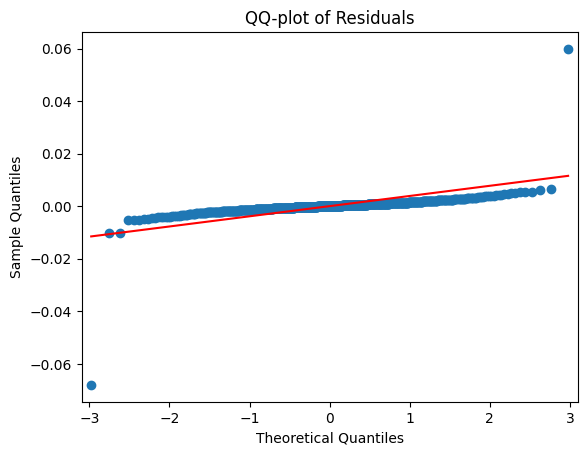

<Figure size 1200x500 with 0 Axes>

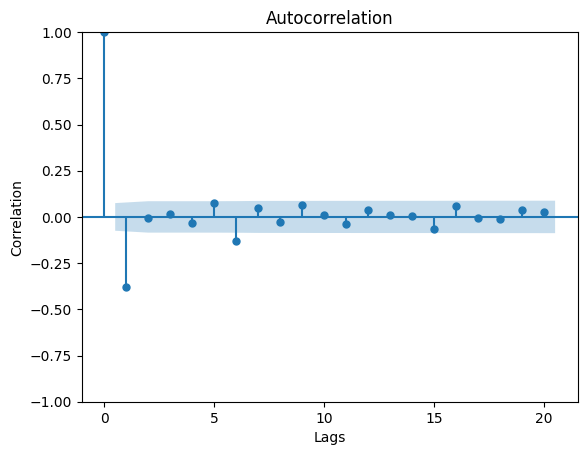

In [135]:



# Summary Metrics
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")
print(f"HQIC: {model_fit.hqic}")
print(f"Residuals: {model_fit.resid.describe()}")
print(f"Correlation: {model_fit.resid.autocorr()}")



# Diagnostic plots
# Plot Residuals
plt.figure(figsize=(12,5))
plt.plot(model_fit.resid)
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Plot Squared residuals of the model
plt.figure(figsize=(12,5))
plt.plot(model_fit.resid**2)
plt.title('Squared Residuals')
plt.xlabel('Date')
plt.ylabel('Squared Residuals')

# plot acf of squared residuals
plt.figure(figsize=(12,5))
plt.plot(acf(model_fit.resid**2, nlags=20), label='ACF', marker="+")
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_returns)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_returns)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('Lags')
plt.ylabel('Correlation')

# plot pacf of squared residuals
plt.figure(figsize=(12,5))
plt.plot(pacf(model_fit.resid**2, nlags=20), label='PACF', marker="+")
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_returns)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_returns)), linestyle='--', color='gray')
plt.title('PACF')
plt.xlabel('Lags')

# Plot QQ-plot of residuals
plt.figure(figsize=(12,5))
qqplot(model_fit.resid, line='s')
plt.title('QQ-plot of Residuals')
plt.xlabel('Theoretical Quantiles')


# Using Plot-ACF
plt.figure(figsize=(12,5))
plot_acf(model_fit.resid, lags=20)
plt.xlabel('Lags')
plt.ylabel('Correlation')


In [136]:
# Heteroskedasticity Test on model_fit., Jarque-Bera test, Ljung-Box test
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

# Interpretation:
# - H0: Normality; If p-value > 0.05, fail to reject H0 (data likely normal)
# - H1: Not normal; If p-value < 0.05, reject H0 (data likely not normal)

# Jarque-Bera test for normality
jb_stats, jb_pvalue = jarque_bera(model_fit.resid)

print(f"Jarque-Bera test statistics: {jb_stats}")
print(f"Jarque-Bera p-value: {jb_pvalue}")

# Ljung-Box test for serial correlation
result_ljungbox = acorr_ljungbox(model_fit.resid, lags=[8], return_df=True, boxpierce=True).reset_index()
print(f"Ljung-Box test statistics: {result_ljungbox['lb_stat'][0]}")
print(f"Ljung-Box p-value: {result_ljungbox['lb_pvalue'][0]}")
print(f"Bow-Pierce test statistics: {result_ljungbox['bp_stat'][0]}")
print(f"Bow-Pierce p-value: {result_ljungbox['bp_pvalue'][0]}")


# Data not normal and serially correlated, so we reject the null hypothesis that the data is normal and serially uncorrelated
# Therefore, the data is heteroskedastic


Jarque-Bera test statistics: 1378592.9395134912
Jarque-Bera p-value: 0.0
Ljung-Box test statistics: 118.53513840588874
Ljung-Box p-value: 6.650955420723915e-22
Bow-Pierce test statistics: 117.8920572364467
Bow-Pierce p-value: 9.027374971538826e-22


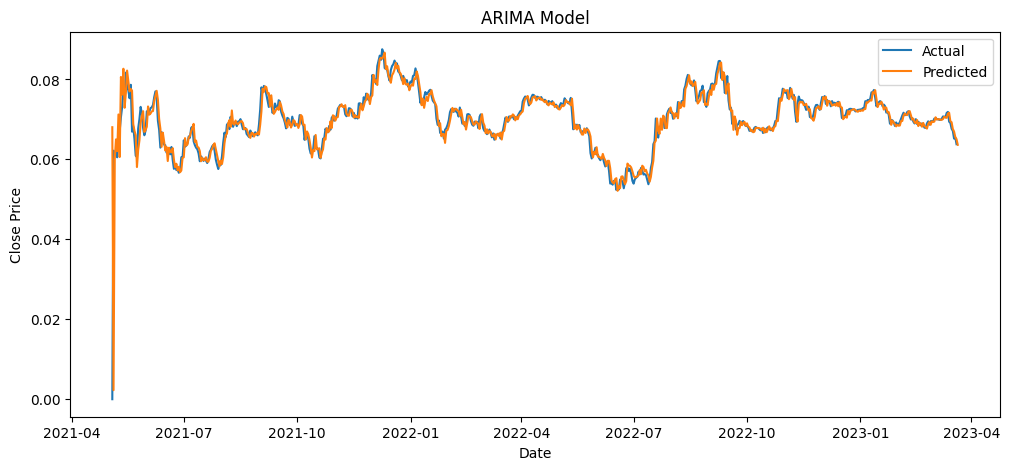

            Close (WBTC)  Predicted Close (WBTC)
2023-03-21      0.062429                0.063646
2023-03-22      0.063983                0.062930
2023-03-23      0.063389                0.063157
2023-03-24      0.064097                0.062483
2023-03-25      0.063734                0.062697
...                  ...                     ...
2024-01-05      0.051293                0.068048
2024-01-06      0.051357                0.068048
2024-01-07      0.051142                0.068048
2024-01-08      0.050622                0.068048
2024-01-09      0.049843                0.068048

[295 rows x 2 columns]


In [137]:
# Predicting and Visualizing with just ARIMA
#test_returns = test_returns.rename(columns={'Close (USDC)': 'Log Returns'})
#df_returns = df_returns.rename(columns={'Close (USDC)': 'Log Returns'})

#forecast = model_fit.predict(start=0, end=df_returns.shape[0] + test_returns.shape[0] - 1)
forecast = model_fit.predict(start=0, end=df_returns.shape[0])


# Final Results for ARIMA
#final_df = pd.concat([df_returns, test_returns], axis=0)
final_df = df_returns
final_df = pd.concat([final_df, forecast], axis=1)
final_df.columns = ['Close (WBTC)', 'Predicted Close (WBTC)']

# Plotting the results
plt.figure(figsize=(12,5))
plt.plot(final_df['Close (WBTC)'], label='Actual')
plt.plot(final_df['Predicted Close (WBTC)'], label='Predicted')
plt.title('ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


# Predicting using test data
#test_returns = test_returns.rename(columns={'Close (USDC)': 'Log Returns'})
forecast_test = model_fit.predict(start=df_returns.shape[0], end=df_returns.shape[0] + test_returns.shape[0] - 1)


# Print or use the forecast_values and confidence_interval as needed
final_df_test = pd.concat([test_returns, forecast_test], axis=1)
final_df_test.columns = ['Close (WBTC)', 'Predicted Close (WBTC)']

print(final_df_test)


In [138]:
# Adding GARCH to the model to account for volatility
from arch import arch_model

arima_residuals = model_fit.resid
standardized_residuals = model_fit.resid / model_fit.resid.std()

# Fit GARCH model to residuals
p=[]
q=[]
aic_values = []
bic_values = []
llfs = []

for i in range(0, 5):
    for j in range(0, 5):
        try:
            garch_model = arch_model(arima_residuals, vol='GARCH',p=i, q=j).fit()
            #garch_model = arch_model(df_returns, vol='GARCH',p=i, q=j).fit()
            print(f'p={i}, q={j}')
            p.append(i)
            q.append(j)
            aic_values.append(garch_model.aic)
            bic_values.append(garch_model.bic)
            llfs.append(garch_model.loglikelihood)
        except:
            continue
        
result_garch = pd.DataFrame({'p':p, 'q':q, 'aic':aic_values, 'bic':bic_values, 'llf':llfs}).sort_values('aic').reset_index(drop=True)
lowest_p, lowest_q = int(result_garch.iloc[0]['p']), int(result_garch.iloc[0]['q'])
print(f"Lowest AIC p: {lowest_p}, q: {lowest_q}")

# Fit GARCH model to residuals
garch_model = arch_model(arima_residuals, vol='GARCH', p=lowest_p, q=lowest_q).fit()


Iteration:      1,   Func. Count:      4,   Neg. LLF: -3363.762397388217
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3363.7623935372303
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
p=1, q=0
Iteration:      1,   Func. Count:      5,   Neg. LLF: -3426.695891506255
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3426.695900819618
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
p=1, q=1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -3417.4648567242984
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3417.464867661507
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
p=1, q=2
Iteration:      1,   Func. Count:      7,   Neg. LLF: -3408.705024843429
Inequality constraints incompatible    (Exit mode 4)
        

C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.501e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

p=3, q=1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -3411.0961715802127
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3411.0961825014447
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
p=3, q=2
Iteration:      1,   Func. Count:      9,   Neg. LLF: -3401.8184270262864
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3401.8184394612217
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
p=3, q=3
Iteration:      1,   Func. Count:     10,   Neg. LLF: -3391.6248155604253
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3391.624829410748
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
p=3, q=4
Iteration:      1,   Func. Count:      8,   Neg. LLF: 1.3565930262067957e+23
Iteration:      2,   Func. Count:     25,   

C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.501e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

In [139]:
# Model Summary
print(garch_model.summary())
print(result_garch)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3426.70
Distribution:                  Normal   AIC:                          -6845.39
Method:            Maximum Likelihood   BIC:                          -6827.27
                                        No. Observations:                  686
Date:                Tue, Jan 09 2024   Df Residuals:                      685
Time:                        16:18:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.6988e-05  1.903e-08   2469.576      0.000 [4.

Log-likelihood: 3426.695900819618
AIC: -6845.391801639236
BIC: -6827.268291128333
Residuals: count    6.860000e+02
mean    -1.289663e-19
std      3.877125e-03
min     -6.809518e-02
25%     -8.576877e-04
50%      5.428833e-05
75%      9.089932e-04
max      5.987465e-02
Name: resid, dtype: float64


<Figure size 1500x600 with 0 Axes>

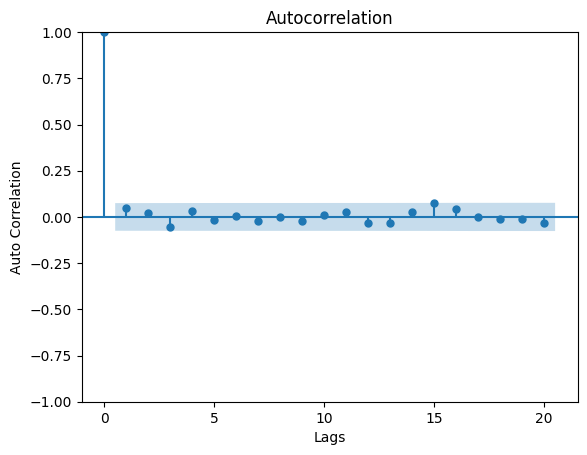

C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1500x600 with 0 Axes>

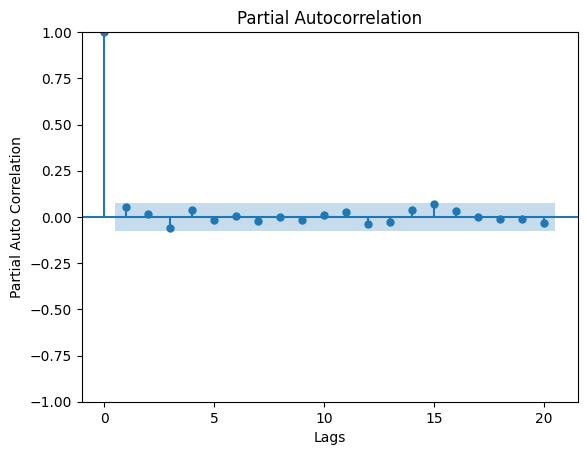

C:\Users\yinki\AppData\Local\Temp\ipykernel_10228\1812885154.py:55: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(garch_model.std_resid, bins=20, ax=ax)


Jarque-Bera test statistics: 1378592.9395134912
Jarque-Bera p-value: 0.0
Ljung-Box test statistics: 118.53513840588874
Ljung-Box p-value: 6.650955420723915e-22
Bow-Pierce test statistics: 117.8920572364467
Bow-Pierce p-value: 9.027374971538826e-22


<Figure size 1200x500 with 0 Axes>

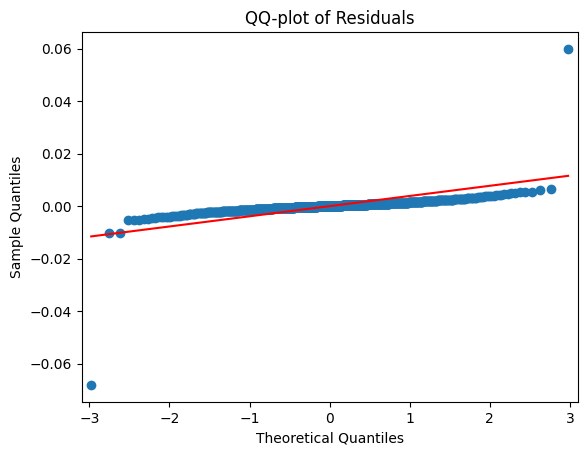

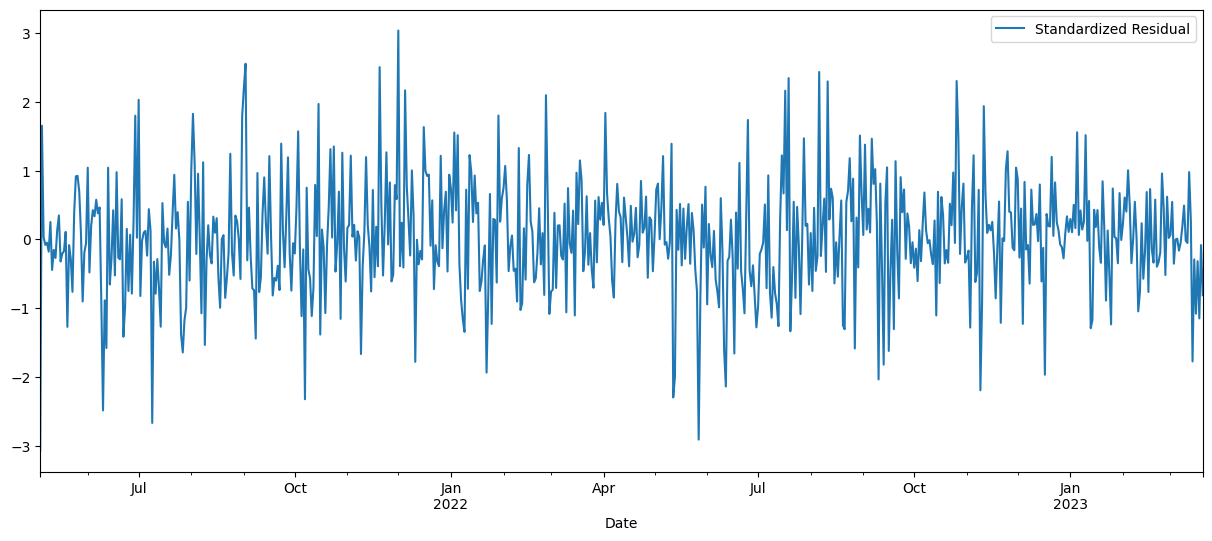

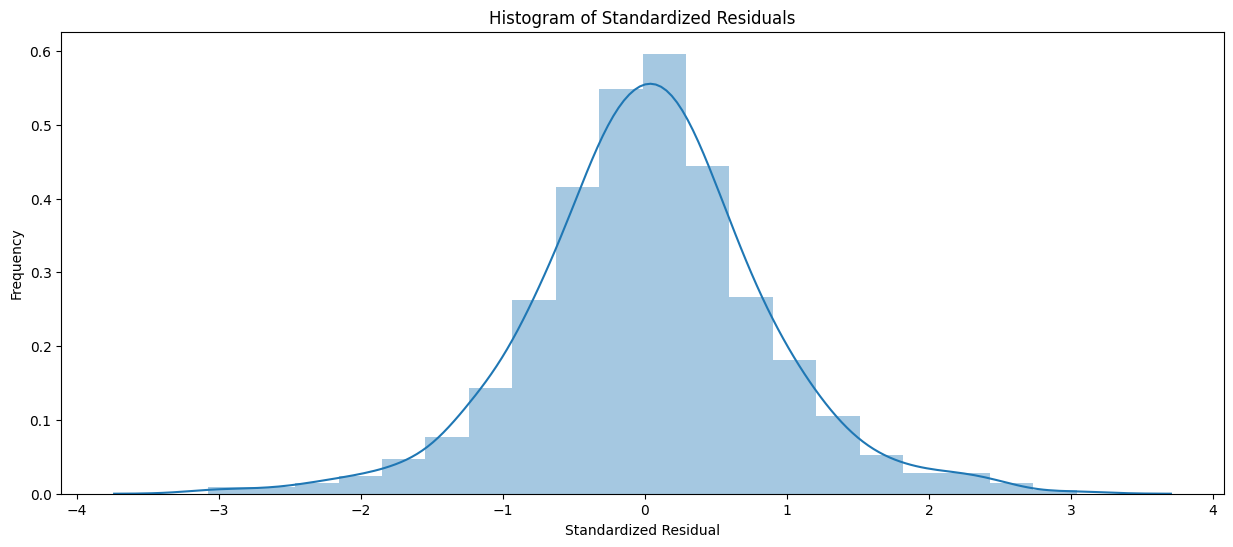

In [140]:
# Key Metrics
print(f"Log-likelihood: {garch_model.loglikelihood}")
print(f"AIC: {garch_model.aic}")
print(f"BIC: {garch_model.bic}")
print(f"Residuals: {garch_model.resid.describe()}")


# Diagnostic plots
# plot acf of squared residuals standardized
plt.figure(figsize=(15,6))
plot_acf(garch_model.std_resid**2, lags=20)
plt.xlabel('Lags')
plt.ylabel('Auto Correlation')
plt.show()
# plot pacf of squared residuals
plt.figure(figsize=(15,6))
plot_pacf(garch_model.std_resid**2, lags=20)
plt.xlabel('Lags')
plt.ylabel('Partial Auto Correlation')
plt.show()

# Plot QQ-plot of residuals
plt.figure(figsize=(12,5))
qqplot(garch_model.resid, line='s')
plt.title('QQ-plot of Residuals')
plt.xlabel('Theoretical Quantiles')


# Interpretation:
# - H0: Normality; If p-value > 0.05, fail to reject H0 (data likely normal)
# - H1: Not normal; If p-value < 0.05, reject H0 (data likely not normal)

# Jarque-Bera test for normality
jb_stats, jb_pvalue = jarque_bera(garch_model.resid)

print(f"Jarque-Bera test statistics: {jb_stats}")
print(f"Jarque-Bera p-value: {jb_pvalue}")

# Ljung-Box test for serial correlation
result_ljungbox = acorr_ljungbox(garch_model.resid, lags=[8], return_df=True, boxpierce=True).reset_index()
print(f"Ljung-Box test statistics: {result_ljungbox['lb_stat'][0]}")
print(f"Ljung-Box p-value: {result_ljungbox['lb_pvalue'][0]}")
print(f"Bow-Pierce test statistics: {result_ljungbox['bp_stat'][0]}")
print(f"Bow-Pierce p-value: {result_ljungbox['bp_pvalue'][0]}")

# Plot standardized residuals
fig, ax = plt.subplots(figsize=(15, 6))
garch_model.std_resid.plot(ax = ax, label = "Standardized Residual")
plt.xlabel("Date")
plt.legend()


# Create histogram of standardized residuals, 20 bins
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(garch_model.std_resid, bins=20, ax=ax)
plt.xlabel("Standardized Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Standardized Residuals")
plt.show()

            Close (WBTC)  Predicted Close (WBTC)  Conditional Volatility
2021-05-04      0.000000                0.068048                0.022163
2021-05-05      0.062183                0.002261                0.036206
2021-05-06      0.061448                0.060124                0.041710
2021-05-07      0.062084                0.065001                0.036846
2021-05-08      0.060522                0.062059                0.032573
...                  ...                     ...                     ...
2023-03-16      0.067668                0.069300                0.001554
2023-03-17      0.067124                0.067603                0.001657
2023-03-18      0.065208                0.066978                0.001580
2023-03-19      0.065491                0.065584                0.001706
2023-03-20      0.063807                0.065064                0.001604

[686 rows x 3 columns]


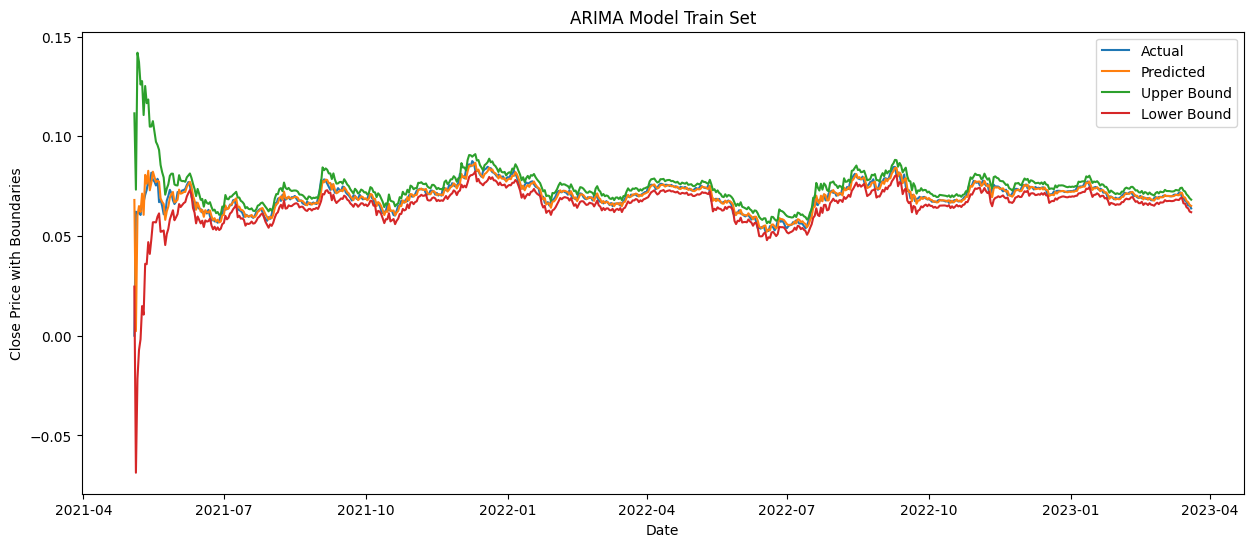

In [141]:
# Combined Model Non Standardized: Final Results = ARIMA + GARCH
garch_volatilities_train = garch_model.conditional_volatility
#print(garch_volatilities_train)
#print(df_returns)

#garch_volatilities_test = garch_model.forecast(horizon=test_returns.shape[0]).variance.iloc[-1, :]
#print(garch_volatilities_test.shape, garch_volatilities_train.shape)
#print(final_df)
#garch_volatilities = pd.concat([garch_volatilities_train, garch_volatilities_test], axis=0)
#print(garch_volatilities.shape, final_df.dropna().shape)

garch_volatilities = pd.DataFrame(garch_volatilities_train)

final_df_garch = pd.concat([final_df.dropna(), garch_volatilities], axis=1)
final_df_garch.columns = final_df_garch.columns[:-1].tolist() + ['Conditional Volatility']
print(final_df_garch)


# Plotting the results + Volatility
plt.figure(figsize=(15, 6))
plt.plot(final_df_garch['Close (WBTC)'], label='Actual')
plt.plot(final_df_garch['Predicted Close (WBTC)'], label='Predicted')
plt.plot(final_df_garch['Predicted Close (WBTC)'] + 1.96 * final_df_garch['Conditional Volatility'] , label='Upper Bound')
plt.plot(final_df_garch['Predicted Close (WBTC)'] - 1.96 * final_df_garch['Conditional Volatility'], label='Lower Bound')
plt.title('ARIMA Model Train Set')
plt.xlabel('Date')
plt.ylabel('Close Price with Boundaries')
plt.legend()
plt.show()


In [155]:
# Walk Forward Validation with ARIMA Model
full_df = pd.concat([df_returns, test_returns], axis=0)
#full_df = df_returns

# Create empty list to hold predictions
predictions_volatility = []
predictions = []
test_date = []

# Calculate size of test data (20%)
#test_size = int(len(test_returns))
test_size = int(len(full_df) * 0.3)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = full_df.iloc[: -(test_size - i)]
    date = full_df.index[-(test_size - i)]

    # Train model
    arima_mod = ARIMA(y_train, order=(p_value, d_value, q_value)).fit()
    
    
    garch_mod = arch_model(arima_mod.resid
                           , vol='GARCH', p=lowest_p, q=lowest_q).fit()

    # Generate next prediction (volatility, not variance)
    pred_volatility = garch_mod.forecast(horizon = 1, reindex = False).variance.iloc[0, 0] ** 0.5
    
    predicted_log_return = arima_mod.forecast(steps=1).values[0]
    print(f"Predicted Close (WBTC): {predicted_log_return}, Predicted Volatility: {pred_volatility}")

    # Append prediction to list
    predictions_volatility.append(pred_volatility)
    predictions.append(predicted_log_return)
    test_date.append(date)


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\loca

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3426.695891506255
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3426.695900819618
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06364563609488387, Predicted Volatility: 0.0016271418465797324


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.499e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3432.292163398739
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3432.292172732889
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0632477224763748, Predicted Volatility: 0.001542935289789161


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.497e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3437.9536034454077
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3437.9536128051336
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06359512750836964, Predicted Volatility: 0.0014684847065894702


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.513e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.0779397635639052e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3458.0193319386635
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3458.019341729642
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
Predicted Close (WBTC): 0.063970368193454, Predicted Volatility: 0.0014638588466319075


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.511e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3463.609039324028
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3463.60904913867
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06423555881498211, Predicted Volatility: 0.0014024806998659861


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.491e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3454.8715948391387
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3454.8716042688193
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06276636264304769, Predicted Volatility: 0.0013821370344343682


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.506e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3474.9180298710316
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3474.918039721767
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06371635521490514, Predicted Volatility: 0.0013877689019607775


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.504e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3480.600355579317
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3480.600365451298
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06300965131030879, Predicted Volatility: 0.001376258069393875


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.502e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3485.5716229230866
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3485.571632754605
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06521551663934769, Predicted Volatility: 0.0015661844078712604


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.5e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packag

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3490.5550411868194
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3490.5550510004127
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06353455425103444, Predicted Volatility: 0.0017190598412256484


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.497e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3496.088936084433
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3496.0889459107057
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06395740895707325, Predicted Volatility: 0.0016175783289964967


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.495e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3501.691762865501
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3501.691772710288
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06425131610822273, Predicted Volatility: 0.0015303087259008591


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.493e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3507.344712509351
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3507.344722377419
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.063909136710458, Predicted Volatility: 0.0014646784343741086


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.491e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3513.022733707572
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3513.0227436012306
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0644204400147559, Predicted Volatility: 0.0014055607764361323


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.488e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3518.655735685838
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3518.6557456024625
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06457199452606358, Predicted Volatility: 0.001365591759274371


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.486e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3523.9007286474325
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3523.9007385394425
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06652629965138497, Predicted Volatility: 0.0015126408537968782


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.484e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3529.248413320711
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3529.248423216312
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0677591587432146, Predicted Volatility: 0.0015149679790752758


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.482e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3534.6811296226006
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3534.681139525568
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06692661531942737, Predicted Volatility: 0.0015212713514074752


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.48e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3540.3165462073293
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3540.316556130404
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06658175986171497, Predicted Volatility: 0.0014559704318408949


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.477e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3545.9852163457927
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3545.985226292263
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06631532354950569, Predicted Volatility: 0.0014016619180440358


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.475e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3551.630310795984
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3551.630320763845
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06588020743017295, Predicted Volatility: 0.0013780908871306363


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.474e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3556.818504676834
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3556.8185146336314
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06491023736602247, Predicted Volatility: 0.001472425105610463


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.472e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.0188929301576145e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3561.5883442946615
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3561.5883542139763
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
Predicted Close (WBTC): 0.06278018073433189, Predicted Volatility: 0.001711960520734277


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.47e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3566.8637324895035
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3566.8637424056014
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06428467661096415, Predicted Volatility: 0.0017131518067496443


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.468e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3571.8285030425614
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3571.8285129452624
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06613077644629177, Predicted Volatility: 0.0017841143100726738


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.466e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3576.0698339949913
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3576.069843855378
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06917130561588998, Predicted Volatility: 0.0020606016119217785


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.464e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3581.4239706134917
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3581.423980483528
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06922599912280152, Predicted Volatility: 0.0019002158436019058


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.462e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3586.8110049651987
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3586.811014850459
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06937379743585737, Predicted Volatility: 0.0017734242043246087


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.46e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3592.2150270313814
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3592.2150369292294
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.07040343361167403, Predicted Volatility: 0.0017231553392797576


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.458e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3597.539953794398
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3597.5399637040696
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06909471519741711, Predicted Volatility: 0.0017095346125049033


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.457e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3602.5210688517236
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3602.5210787561045
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0679381525007071, Predicted Volatility: 0.001753233917865306


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.455e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3607.9000128788857
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3607.900022798636
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06844029181245839, Predicted Volatility: 0.0016703142899133477


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.453e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3613.245588649628
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3613.2455985857887
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06778786414513448, Predicted Volatility: 0.001609283704038331


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.451e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3618.8317398229983
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3618.8317497863572
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06793634346461033, Predicted Volatility: 0.0015222006969357672


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.449e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3624.460336977055
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3624.4603469675094
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06741854336635876, Predicted Volatility: 0.0014650908366420367


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.447e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3630.122442430752
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3630.122452451973
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06689165538736612, Predicted Volatility: 0.0014074016146414584


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.445e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3635.610776272721
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3635.6107863122243
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06648475100645897, Predicted Volatility: 0.0013981166170024776


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.443e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3641.306551783093
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3641.306561846841
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06564231203422448, Predicted Volatility: 0.0013808620856181793


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.442e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3646.7273533199245
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3646.7273633940626
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06488023671747796, Predicted Volatility: 0.001398101334401897


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.439e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3652.461507781267
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3652.4615178825607
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06474952577349637, Predicted Volatility: 0.001349384039037655


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.437e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3658.219849234444
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3658.2198593630806
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06521891260141968, Predicted Volatility: 0.0013127319992517835


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.435e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3663.809031898327
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3663.809042039663
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06442707126705352, Predicted Volatility: 0.0013388069409127088


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.433e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.047215002984734e+21
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3669.5479655628346
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3669.547975723744
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
Predicted Close (WBTC): 0.06530077395017005, Predicted Volatility: 0.0013300078324625882


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.431e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3675.306446437272
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3675.3064566239836
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06509690029326548, Predicted Volatility: 0.0012903051883266998


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.429e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3681.107857525508
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3681.107867737199
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06563326997614502, Predicted Volatility: 0.0012680031366739477


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.427e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3686.8977625922826
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3686.8977728282935
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06546333656510679, Predicted Volatility: 0.0012547493364879702


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.425e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3691.7990805794807
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3691.7990907744033
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06699270352795325, Predicted Volatility: 0.0014292440110891093


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.424e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3697.0371243862423
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3697.037134577414
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06606504000654206, Predicted Volatility: 0.001480853945908695


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.422e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3702.716791669697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3702.7168018774637
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06621827420314874, Predicted Volatility: 0.0014121247721670675


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.42e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3708.4036308603845
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3708.4036410849576
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06681238483988791, Predicted Volatility: 0.0013734005546566115


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.418e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3714.161218832525
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3714.16122908027
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06680127922811312, Predicted Volatility: 0.0013246923562334524


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.416e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3719.9574793124816
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3719.957489586104
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06738120347033626, Predicted Volatility: 0.0012847086867290504


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.414e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3725.6428908037315
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3725.6429010881657
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06621159213551638, Predicted Volatility: 0.001323167633949934


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.411e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3731.1059245547644
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3731.1059348335334
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06765394815172178, Predicted Volatility: 0.001409206127869479


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.41e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3736.7461435901023
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3736.7461538832395
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06709204840678112, Predicted Volatility: 0.001385543478206787


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.408e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3742.4925331405266
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3742.4925434549314
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06710944098547705, Predicted Volatility: 0.0013351988030052254


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.406e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3748.2270837970664
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3748.2270941323277
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06676755435769437, Predicted Volatility: 0.0013062957799771049


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.404e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3753.9505992724544
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3753.950609626698
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06719669796868705, Predicted Volatility: 0.0012915508340320672


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.402e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3759.680881058808
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3759.680891434091
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06708491924208426, Predicted Volatility: 0.0012732349648230466


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.4e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3765.510056113548
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3765.510066514669
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06709942914147501, Predicted Volatility: 0.0012422991506661747


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.398e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3771.3660680994867
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3771.366078526994
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06743407006796924, Predicted Volatility: 0.0012210280077075972


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.396e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3777.2434095103445
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3777.2434199652766
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06729394028556837, Predicted Volatility: 0.0012015393363144992


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.38e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3767.3758565262124
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3767.3758666100603
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06750094482801669, Predicted Volatility: 0.0011790437455154324


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.389e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3772.3020494578095
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3772.3020596676897
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06746774689623486, Predicted Volatility: 0.0011682762642304446


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.388e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3778.1566397923257
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3778.156650028687
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06793664256812511, Predicted Volatility: 0.001167453765508373


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.387e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3783.950432243576
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3783.9504425089663
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06802452312580283, Predicted Volatility: 0.0011577730289057807


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.373e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3790.9699444871067
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3790.9699546773886
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06827227809154661, Predicted Volatility: 0.0011463530080799056


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.341e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3815.2210543048072
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3815.2210646336052
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06816558095524893, Predicted Volatility: 0.0011294008351780175


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.338e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3821.2196750974363
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3821.2196854474178
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06818971459378721, Predicted Volatility: 0.0011228627529473961


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.368e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3808.7167000905006
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3808.716710358563
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0679301172645726, Predicted Volatility: 0.0011494165541276605


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.335e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3833.001444744231
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3833.001455140449
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06810121296076632, Predicted Volatility: 0.001132608380139979


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.333e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3838.943841891817
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3838.943852309666
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06837124993852431, Predicted Volatility: 0.0011299785329335784


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.332e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3844.851810464265
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3844.8518209083622
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06867911846876484, Predicted Volatility: 0.0011273703917162796


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.33e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3850.718711691978
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3850.718722154995
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06922010687233762, Predicted Volatility: 0.0011397898866473942


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.329e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3856.5370464858756
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3856.5370569717456
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06960296935205429, Predicted Volatility: 0.0011481103617803526


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.327e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3862.4932316830927
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3862.4932421897506
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06974375060487714, Predicted Volatility: 0.0011372319230009773


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.356e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3850.013700042701
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3850.013710465746
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06973165419973532, Predicted Volatility: 0.0011428031596499536


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.355e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3855.854640898204
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3855.854651339524
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.07036284050438123, Predicted Volatility: 0.001158905778683598


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.365e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3877.2523289889587
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3877.2523398182348
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0693761999162526, Predicted Volatility: 0.0012268709635712969


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.363e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3883.1027148171343
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3883.102725664775
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06971660303271367, Predicted Volatility: 0.001209398666763721


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.361e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3888.9925179344796
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3888.9925288034447
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06959548394203617, Predicted Volatility: 0.0011886976689713233


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.36e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3894.86994887739
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3894.8699597675704
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06930649600488235, Predicted Volatility: 0.0011776661462913733


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.358e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3899.7826002853353
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3899.7826111352942
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0679386781949959, Predicted Volatility: 0.0013651287658877054


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.356e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3905.55752993805
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3905.557540802505
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06757615358614248, Predicted Volatility: 0.0013139559698045439


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.312e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5.668582564530628e+21
Iteration:      2,   Func. Count:     19,   Neg. LLF: -3913.9849784015296
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3913.984988995091
            Iterations: 2
            Function evaluations: 19
            Gradient evaluations: 2
Predicted Close (WBTC): 0.06731650935779776, Predicted Volatility: 0.0012666092666903804


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.31e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3919.796970537675
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3919.796981152011
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.067132077168692, Predicted Volatility: 0.001231873584762405


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.308e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3925.111272210871
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3925.11128280328
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0660436826425515, Predicted Volatility: 0.0013411705265021462


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.306e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3930.753580041611
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3930.753590639413
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06503974058820464, Predicted Volatility: 0.0013422426229655058


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.304e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3936.5429038724674
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3936.542914488983
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06532935495222637, Predicted Volatility: 0.0012917116988424996


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.332e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3923.9674988205916
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3923.967509370801
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06500033643879181, Predicted Volatility: 0.0012364908541171408


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.331e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3929.8757023631574
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3929.8757129406354
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06552607210242672, Predicted Volatility: 0.0012159580675385644


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.341e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3951.191802338123
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3951.1918133014806
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06482090327451756, Predicted Volatility: 0.0012680649974668237


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.328e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3940.8094113260386
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3940.809421899884
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0633056257527829, Predicted Volatility: 0.0013500269672322093


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.326e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3947.595241901921
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3947.595252518292
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06274404152041096, Predicted Volatility: 0.001325864757297901


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.337e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3967.6703898008254
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3967.6704007725916
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06287187745279943, Predicted Volatility: 0.001319522155975097


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.335e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3973.1000777380214
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3973.1000887104483
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06205864654731074, Predicted Volatility: 0.0013719796188972908


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.334e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3978.837750388612
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3978.837761378769
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06196038376242319, Predicted Volatility: 0.0013283927678633348


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.332e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3984.616385390298
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3984.6163964006514
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06228222809615054, Predicted Volatility: 0.001287176034907314


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.33e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3990.3116081636845
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3990.31161919084
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06187184571088751, Predicted Volatility: 0.001280104910533019


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.328e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3996.1572798958555
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3996.1572909471215
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06225063895541737, Predicted Volatility: 0.0012420859183875238


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.327e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4001.640007206554
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4001.6400182549605
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06114258585861944, Predicted Volatility: 0.0013240071732145784


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.28e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\sit

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4010.321965849395
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4010.321976602718
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06104025809485484, Predicted Volatility: 0.0012658139726705363


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.323e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4011.6936915048736
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4011.693702489052
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06363940519164696, Predicted Volatility: 0.0015935880984899822


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.278e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4020.0373528329064
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4020.037363522766
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0631031093890389, Predicted Volatility: 0.001513779681088656


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.319e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4022.953947343191
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4022.9539583532514
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06383969776847259, Predicted Volatility: 0.0014437905101094492


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.318e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4028.5504977671885
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4028.5505087889724
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06296081440053453, Predicted Volatility: 0.0014301927039488684


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.273e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4037.073445621091
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4037.0734563562237
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06285763076154252, Predicted Volatility: 0.0013487705522990119


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.314e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4040.034340767016
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4040.0343518359214
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06334207569723836, Predicted Volatility: 0.001310305003240132


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.313e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4045.5128396552727
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4045.512850720447
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.062079753697626236, Predicted Volatility: 0.0013990790885099764


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.298e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4035.3246244681145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4035.3246351468733
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.062454542014677636, Predicted Volatility: 0.0013897875564333419


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.309e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4056.91084329821
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4056.910854400943
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06161513295836785, Predicted Volatility: 0.0013244278725144379


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.264e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4065.592125999075
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4065.5921368087893
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06199479028077307, Predicted Volatility: 0.0012637827608325217


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.262e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4071.4397065377575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4071.439717373741
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.062076070136778363, Predicted Volatility: 0.0012269484201445726


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.26e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4077.1284624609048
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4077.128473306895
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06142703254320231, Predicted Volatility: 0.001252670626361811


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.258e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4082.9809318564676
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4082.9809427262353
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.061850291506366985, Predicted Volatility: 0.0012172492848373725


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.258e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4087.7240848761962
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4087.724095707801
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06362145733659391, Predicted Volatility: 0.0014044294271873118


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.257e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4093.436827913586
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4093.4368387656104
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06399929217628834, Predicted Volatility: 0.001337626032285406


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.297e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4096.400060413951
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4096.400071591383
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0639613878526581, Predicted Volatility: 0.0013149956891311406


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.296e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4102.204590962658
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4102.204602162526
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06372372716196455, Predicted Volatility: 0.0012727910460491217


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.252e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4110.8199568039145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4110.819967714808
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06328541490520462, Predicted Volatility: 0.0012303209980627514


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.25e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4116.674066911266
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4116.674077850053
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06387680598578924, Predicted Volatility: 0.0011983145399225696


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.248e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4122.53318483178
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4122.533195785696
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06342705313350129, Predicted Volatility: 0.0012030771980027224


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.289e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4125.555065027375
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4125.55507632128
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06365975635269495, Predicted Volatility: 0.0011899083867955237


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.287e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4131.450163917585
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4131.450175237682
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06366353773727358, Predicted Volatility: 0.0011704047520464391


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.286e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4137.031295451632
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4137.031306773266
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0627756784867999, Predicted Volatility: 0.0012376083925827515


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.281e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4125.32078828044
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4125.320799287554
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06298640771803678, Predicted Volatility: 0.00122583030122161


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.282e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4148.7266835488645
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4148.726694910477
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06352992761619394, Predicted Volatility: 0.001194144889028714


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.281e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4154.639433608716
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4154.639444994701
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06384525015833804, Predicted Volatility: 0.0011694955687064246


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.279e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4160.551876593194
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4160.551888003216
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06387939532773769, Predicted Volatility: 0.0011557973415620283


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.277e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4166.488848920395
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4166.488860355232
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06369243950173958, Predicted Volatility: 0.0011431471342944841


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.276e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4172.438448722593
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4172.438460181866
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06401951040342427, Predicted Volatility: 0.0011318224213900756


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.274e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4178.404361796213
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4178.404373281495
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06420405130264703, Predicted Volatility: 0.00111952169657328


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.286e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4161.744135931978
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4161.744147071418
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06415917026662873, Predicted Volatility: 0.001129256624098272


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.23e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4193.189064886999
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4193.189076105178
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06375199058969339, Predicted Volatility: 0.0011067813875506585


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.228e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4199.094818504496
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4199.094829739239
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06340930340495082, Predicted Volatility: 0.0011170879181956455


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.226e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4205.014187484283
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4205.014198734585
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0631431313033565, Predicted Volatility: 0.0011224462501459526


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.225e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4210.959916552988
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4210.959927827493
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06315449771308222, Predicted Volatility: 0.0011104936324778023


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.223e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4216.96452083408
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4216.964532128178
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06315107874822981, Predicted Volatility: 0.0011009095459860708


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.221e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4222.946853481622
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4222.946864799765
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06321560088420486, Predicted Volatility: 0.0010923371064642837


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.219e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4228.942237439015
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4228.942248779304
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06318332042495639, Predicted Volatility: 0.0010874377331742927


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.218e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4234.82251434466
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4234.822525697561
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06274006635520218, Predicted Volatility: 0.001112527336122719


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.216e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4240.721721232332
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4240.721732600744
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06244115990870929, Predicted Volatility: 0.0011206023778079141


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.214e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4246.6903253930295
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4246.690336781929
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06273487410475662, Predicted Volatility: 0.0011068866526229978


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.255e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4249.556835161889
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4249.556846897746
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06291473844097215, Predicted Volatility: 0.001112312886439026


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.212e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4258.636746689786
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4258.636758127129
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06291568459346003, Predicted Volatility: 0.0010884224454487665


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.21e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4264.634960016389
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4264.634971476176
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06286826511734195, Predicted Volatility: 0.0010837274238120593


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.251e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4267.471389753284
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4267.471401563535
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06300603188820403, Predicted Volatility: 0.0010932328307900622


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.249e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4273.43387811016
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4273.433889942093
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06292542184222011, Predicted Volatility: 0.001096324345037844


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.248e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4279.421816804614
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4279.421828658898
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06284348070520285, Predicted Volatility: 0.0010950941534563009


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.246e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4285.423926268628
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4285.423938146164
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06291836090570618, Predicted Volatility: 0.0010891470255252821


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.244e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4291.344538147117
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4291.344550041547
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06353739649627788, Predicted Volatility: 0.001100919348980763


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.243e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4297.343373992058
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4297.343385909015
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06382637275689543, Predicted Volatility: 0.001092398009666144


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.241e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4303.331373548845
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4303.331385487705
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06417961388431341, Predicted Volatility: 0.0010883318056875964


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.24e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4309.343347921365
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4309.343359883753
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06431621448995659, Predicted Volatility: 0.0010820936818181938


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.238e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4315.297008283431
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4315.297020265662
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06401054300788918, Predicted Volatility: 0.0010929121351148487


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.237e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4320.565836628972
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4320.565848589349
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06294515294992757, Predicted Volatility: 0.0012330397151737518


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.235e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4326.400570345055
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4326.400582317607
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06336985232381019, Predicted Volatility: 0.001206858218274646


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.234e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4332.305436997962
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4332.3054489888755
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06346310380049315, Predicted Volatility: 0.0011765032556910703


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.232e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4338.24179115351
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4338.241803165367
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06369231941246226, Predicted Volatility: 0.0011512160721711604


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.231e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4344.174189409534
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4344.174201442438
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06367759649337623, Predicted Volatility: 0.0011381737445369812


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.229e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4350.122991384691
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4350.123003439459
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06330372139467118, Predicted Volatility: 0.0011294260821673547


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.228e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4356.099629097435
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4356.099641176008
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06365618004533082, Predicted Volatility: 0.001113798477146022


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.226e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4361.660675340472
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4361.660687412528
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06263700387016424, Predicted Volatility: 0.001211917861812711


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.183e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4370.888360090827
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4370.888371848869
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06274608584876824, Predicted Volatility: 0.001163343324630003


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.182e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4376.737678256595
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4376.737690034257
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06324997571305796, Predicted Volatility: 0.0011486386992048093


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.181e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4382.675020878964
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4382.675032678303
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06322234899504839, Predicted Volatility: 0.0011301308125094892


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.179e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4388.641355768505
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4388.641367591859
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0634327366532307, Predicted Volatility: 0.0011103223681008189


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.178e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4394.608788589783
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4394.608800433469
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06306929031454471, Predicted Volatility: 0.0011074497305902484


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.176e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4400.592649201073
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4400.592661069878
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0631723985212294, Predicted Volatility: 0.0010915304733482049


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.175e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4406.56892874334
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4406.568940638215
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06353884455459789, Predicted Volatility: 0.0010803514011114772


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.174e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4412.579784986223
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4412.5797969070245
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06353882123439647, Predicted Volatility: 0.0010715730444196157


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.172e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4418.382373404229
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4418.382385331704
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0630472416951077, Predicted Volatility: 0.0011139558277195587


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.171e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4424.360801564206
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4424.360813514304
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06303488739998027, Predicted Volatility: 0.0010977194189686604


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.169e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4430.35762018519
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4430.357632159024
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0630528983360716, Predicted Volatility: 0.001083937698217074


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.168e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4436.296136208988
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4436.2961481975235
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06277612082800486, Predicted Volatility: 0.0010964045518695137


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.166e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4441.7111204364755
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4441.711132398401
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.061755275924656294, Predicted Volatility: 0.0012261329431118835


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.164e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4447.592969452923
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4447.592981427213
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06142146493305899, Predicted Volatility: 0.0011979008621103183


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.163e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4453.5004764886635
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4453.500488480198
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06140723005628069, Predicted Volatility: 0.0011662192868506494


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.161e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4459.448314477917
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4459.448326489728
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.061465325510830254, Predicted Volatility: 0.001140182028904227


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.16e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\sit

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4465.413829193447
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4465.413841228672
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.061690095496323386, Predicted Volatility: 0.001116137508964569


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.158e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4471.404860715886
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4471.40487277463
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06159310259744229, Predicted Volatility: 0.0011000792513596747


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.157e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4477.370866229369
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4477.370878308815
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06149346688941089, Predicted Volatility: 0.001094882850276271


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.155e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4483.335209655802
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4483.335221753094
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06117718578331425, Predicted Volatility: 0.001100542291275851


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.153e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4489.182931662839
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4489.182943768104
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06065693200263655, Predicted Volatility: 0.0011308778167587984


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.152e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4495.0091850295385
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4495.009197141792
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06015970719636022, Predicted Volatility: 0.0011550670429263984


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.151e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4500.856499422785
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4500.856511554047
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.059889404311074076, Predicted Volatility: 0.0011507410395574778


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.192e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4503.142589030018
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4503.142601538488
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06013322287254143, Predicted Volatility: 0.0011396474159812123


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.19e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4509.11000810532
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4509.110020636406
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.060224701008286946, Predicted Volatility: 0.0011218234812838085


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.189e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4515.103628711409
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4515.103641266366
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.060321004280129736, Predicted Volatility: 0.0011057033512391794


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.175e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4503.852322795414
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4503.8523349201805
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06054207264099525, Predicted Volatility: 0.0010972552671693033


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.181e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4508.941124498915
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4508.941136743466
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06069013338458316, Predicted Volatility: 0.0010819671101398192


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.171e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4516.083673746222
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4516.0836859127285
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06109890598627971, Predicted Volatility: 0.0010719477015752837


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.17e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4521.901578846277
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4521.901591040365
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06154710408235738, Predicted Volatility: 0.0010639158087849135


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.178e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4527.084882026686
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4527.084894352065
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06229218372937397, Predicted Volatility: 0.0010710805311638088


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.168e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4533.861324762572
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4533.861337005813
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06243219997561126, Predicted Volatility: 0.0010653888136840414


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.175e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4538.7827017911
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4538.782714148783
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.062241944852162695, Predicted Volatility: 0.0010930832088819624


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.171e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4543.750615724572
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4543.75062797258
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06066251250273386, Predicted Volatility: 0.0014128318094981788


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.185e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4544.013168921997
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4544.0131811512165
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.06050056347512785, Predicted Volatility: 0.0013502787664964363


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.161e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4555.606113919916
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4555.6061260846745
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05992547857637349, Predicted Volatility: 0.0013987084753071155


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.167e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4560.78742253613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4560.787434813306
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05900960161807472, Predicted Volatility: 0.0014019606757932166


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.131e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4588.200853171575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4588.200865492921
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05916289703512784, Predicted Volatility: 0.0012591263308008472


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.157e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4572.463853332265
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4572.463865518813
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.058282813384222226, Predicted Volatility: 0.0013476752113788437


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.164e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4577.298693575961
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4577.298705893098
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05855602086214769, Predicted Volatility: 0.0012757625711449757


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.125e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4605.321387647053
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4605.321399953281
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.057400343943794445, Predicted Volatility: 0.0013672218926781496


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.123e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4611.1638654574235
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4611.163877772295
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05724589224009928, Predicted Volatility: 0.0013063059232648897


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.123e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4616.481496349257
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4616.481508675868
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05853827725357174, Predicted Volatility: 0.0013301030783348482


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.12e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4622.173923379642
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4622.173935698442
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.057681542040617, Predicted Volatility: 0.001365440839814017


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.119e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4627.944668510247
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4627.944680848843
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05825530215867658, Predicted Volatility: 0.001295745140423581


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.118e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4633.776661319551
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4633.7766736795675
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.057857996687490885, Predicted Volatility: 0.0012553026931714992


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.116e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4639.663941433828
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4639.66395381083
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05763969488078958, Predicted Volatility: 0.0012189196385807156


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.114e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4644.856653994213
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4644.85666633156
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05660323397006389, Predicted Volatility: 0.0013708245708982081


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.111e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4650.306380928347
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4650.306393238446
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.054949763167704994, Predicted Volatility: 0.0015058357499071282


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.11e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4655.979936616166
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4655.979948941169
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.055447479044845926, Predicted Volatility: 0.0014121168584766198


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.108e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4661.679292317294
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4661.679304649137
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05483639161052664, Predicted Volatility: 0.0013950847420935847


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.107e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4667.418377211421
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4667.418389552856
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05458046412967284, Predicted Volatility: 0.001359985688079461


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.105e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4673.270376079333
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4673.270388436476
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.054411270239105136, Predicted Volatility: 0.001302209341246646


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.105e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4678.718058199924
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4678.718070575405
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05542334608490917, Predicted Volatility: 0.0012995799363357402


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.102e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4683.660019204852
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4683.660031517935
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05397511469873882, Predicted Volatility: 0.0015158884246432604


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.1e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packag

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4689.187700526963
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4689.187712832851
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05281123594339858, Predicted Volatility: 0.0015574353019299678


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.13e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4673.445282560652
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4673.445294833402
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05225952686741943, Predicted Volatility: 0.001504989722507717


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.099e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4700.00905683159
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4700.009069158472
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05283436760340947, Predicted Volatility: 0.001486506737538239


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.095e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4705.908504968424
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4705.908517296106
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05323680171987555, Predicted Volatility: 0.0014009479257261405


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.093e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4711.730972901441
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4711.730985227909
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.052389516526375315, Predicted Volatility: 0.001412045134875767


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.091e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4717.522914813906
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4717.522927153407
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05234662346965675, Predicted Volatility: 0.0013436320098585111


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.09e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4723.273820577115
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4723.273832949124
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.052402957160197085, Predicted Volatility: 0.0012749913216755344


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.122e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4707.973389572944
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4707.973401968005
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.052951940433796134, Predicted Volatility: 0.0012038722551433697


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.086e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4735.06471492726
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4735.064727345351
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05252654433230709, Predicted Volatility: 0.0012158231959696006


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.084e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4740.894062077228
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4740.894074495919
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.051987902909499895, Predicted Volatility: 0.001235523812872449


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.083e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4746.507200796697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4746.507213233852
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05291287980552643, Predicted Volatility: 0.0012243053027740658


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.082e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4752.3845523749505
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4752.384564842017
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05330045228165304, Predicted Volatility: 0.0011768364705434773


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.082e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4758.007155589473
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4758.00716808134
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0543093699664029, Predicted Volatility: 0.0011692506182541039


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.081e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.6326730688405e+23
Iteration:      2,   Func. Count:     20,   Neg. LLF: -4730.602111466378
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4730.60212291573
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
Predicted Close (WBTC): 0.054516375036819976, Predicted Volatility: 0.001164592011627612


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.078e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4769.576607849412
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4769.576620342725
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0534269306009886, Predicted Volatility: 0.0012432521809276204


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.077e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4775.407818944418
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4775.407831447389
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05321518458066754, Predicted Volatility: 0.0012235856423108854


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.13e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4768.988967176685
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4768.988979755488
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05781464254584523, Predicted Volatility: 0.002317179195592256


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.08e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4778.454449736145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4778.454461844623
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.056402712123493876, Predicted Volatility: 0.0022642989994434578


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.078e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4783.822828598222
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4783.822840700996
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05599759382856552, Predicted Volatility: 0.0020985392445697633


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.076e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4789.234142849722
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4789.234154955881
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.055270364395907545, Predicted Volatility: 0.0019410603237560665


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.076e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4794.334241738246
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4794.334253861783
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05609162376221073, Predicted Volatility: 0.0018478378923885799


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.074e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4799.781728873185
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4799.78174101663
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05704299910326847, Predicted Volatility: 0.0017002686891664156


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.07e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4805.486256919299
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4805.486269008142
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05445252095920065, Predicted Volatility: 0.0019375112935288699


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.069e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4810.857668949972
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4810.857681054037
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05475370728335523, Predicted Volatility: 0.0017728844943852712


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.067e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4816.378970526766
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4816.378982636508
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.053653401006559465, Predicted Volatility: 0.0017005393879185684


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.066e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4821.941760609014
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4821.941772746939
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05414013984717825, Predicted Volatility: 0.0015710406407215343


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.064e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4827.618338564985
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4827.618350732539
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05404244756797402, Predicted Volatility: 0.0014735019683944208


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.064e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4833.273628998078
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4833.273641205675
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.054360839816929934, Predicted Volatility: 0.0013815814865760624


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.062e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4839.053012885934
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4839.053025125173
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05438338597827186, Predicted Volatility: 0.001313795535718508


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.113e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4839.618060386755
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4839.61807316195
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05543681799704271, Predicted Volatility: 0.0013164078020960525


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.112e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4845.448572060281
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4845.448584871892
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.055796490586094705, Predicted Volatility: 0.00125450858058215


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.111e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4851.240055646054
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4851.240068486148
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05546252505323772, Predicted Volatility: 0.0012354055222038463


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.11e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4857.116316239037
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4857.116329113017
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05548981509080423, Predicted Volatility: 0.00119565002391812


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.108e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4863.0408290170035
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4863.040841925697
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05530475342799301, Predicted Volatility: 0.0011617433414747192


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.107e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4868.711465024348
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4868.711477947147
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05492483148364871, Predicted Volatility: 0.0011865502889647705


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.106e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4874.537961173792
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4874.537974115665
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05449989876894833, Predicted Volatility: 0.0011907070478454833


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.105e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7.972573286562564e+22
Iteration:      2,   Func. Count:     21,   Neg. LLF: 9.484022560502292e+21
Iteration:      3,   Func. Count:     36,   Neg. LLF: 2.678524897350301e+22
Iteration:      4,   Func. Count:     45,   Neg. LLF: 234049220503.30573
Iteration:      5,   Func. Count:     58,   Neg. LLF: 579433.5072096803
Iteration:      6,   Func. Count:     70,   Neg. LLF: -4881.179187114974
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4881.179199897306
            Iterations: 8
            Function evaluations: 70
            Gradient evaluations: 6
Predicted Close (WBTC): 0.05406203987721635, Predicted Volatility: 0.0011733671843403392


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.104e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4886.237907296254
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4886.23792027995
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05459849896193482, Predicted Volatility: 0.0011574485916196644


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.081e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4876.245402801453
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4876.245415260994
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.054388734218246644, Predicted Volatility: 0.0011799904504531335


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.082e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4881.862482054153
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4881.8624945704505
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05497229991384892, Predicted Volatility: 0.0011638598216342853


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.086e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4887.052315884374
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4887.052328512356
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05535064968460135, Predicted Volatility: 0.0011232445165886805


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.099e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4908.670149477983
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4908.670162455484
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05363543778653143, Predicted Volatility: 0.0013680734763675793


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.098e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4913.815356640898
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4913.815369606324
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.052451320305450515, Predicted Volatility: 0.0014664487182971392


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.097e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4919.330147658346
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4919.330160628313
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05132180608433475, Predicted Volatility: 0.0014706238860270199


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.042e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4927.810763929408
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4927.810776241746
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.054740727193778094, Predicted Volatility: 0.0019790370935325262


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.039e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4933.280688859324
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4933.28070115832
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.053903914490136345, Predicted Volatility: 0.0019116200831477527


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.038e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.1504326612245645e+23
Iteration:      2,   Func. Count:     20,   Neg. LLF: -4934.7798782691825
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4934.779890410815
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
Predicted Close (WBTC): 0.05401850999438562, Predicted Volatility: 0.0017376792326553446


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.037e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4944.278296578623
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4944.278308902328
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05396664556451339, Predicted Volatility: 0.0016150194847867625


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.035e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4949.938598904323
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4949.938611247403
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0535553740197134, Predicted Volatility: 0.001499591033959434


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.034e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4955.583493187606
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4955.583505544251
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05384207610920692, Predicted Volatility: 0.0014219292748463195


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.031e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4961.4299996802065
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4961.43001203222
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.052570291578449946, Predicted Volatility: 0.0014448979635560315


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.031e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4966.740640827753
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4966.740653202566
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05416907106357714, Predicted Volatility: 0.0014578932863373102


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.029e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4972.3811252328
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4972.3811375982
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05325054577339217, Predicted Volatility: 0.0014634207720389293


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.027e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4978.139980336926
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4978.139992719622
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.053286878749662696, Predicted Volatility: 0.0013792801570122236


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.083e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4978.33824137541
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4978.338254382362
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.053460033296409006, Predicted Volatility: 0.0013189478586172908


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.023e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4989.475142193469
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4989.475154579988
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05223087488260291, Predicted Volatility: 0.0013579848240487574


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.082e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4989.345579435218
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4989.345592455967
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05209440958599178, Predicted Volatility: 0.0013410673292899508


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.018e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5000.690218364372
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5000.690230704117
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.050399266773962906, Predicted Volatility: 0.0014657309431860056


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.018e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5006.237755703667
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5006.237768067324
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05124019026670225, Predicted Volatility: 0.0013963795844556997


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.02e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5010.9093325317735
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5010.909344904059
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05321755433789722, Predicted Volatility: 0.0014959408776515834


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.018e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5016.691904578231
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5016.691916959135
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05296448319716553, Predicted Volatility: 0.001418072580311521


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.016e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5022.463463969775
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5022.463476361997
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05295205785942805, Predicted Volatility: 0.0013457941708034029


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.014e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5028.29618758445
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5028.296199982449
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.052170167627441484, Predicted Volatility: 0.0013131222756335927


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.073e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5028.191551017029
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5028.1915640798115
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05265528236770932, Predicted Volatility: 0.0012697133028667013


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.016e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5038.0612332258115
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5038.061245610388
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.055064438454441075, Predicted Volatility: 0.0015034629703878262


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.015e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5043.698638958793
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5043.698651360288
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05543713192471666, Predicted Volatility: 0.0014021229145714592


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.012e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5049.36436838368
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5049.3643807806075
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05496923799942079, Predicted Volatility: 0.0013769142710738412


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.011e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5055.15422307843
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5055.154235482697
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05446226562317098, Predicted Volatility: 0.001325987792278229


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.009e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5060.978440912804
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5060.978453329644
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.0539254350050207, Predicted Volatility: 0.0012753200426668478


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.066e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5060.937215654745
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5060.937228713188
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.053788351309063856, Predicted Volatility: 0.0012699760350172466


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.065e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5066.460214204703
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5066.460227260043
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05285040829698737, Predicted Volatility: 0.0013349256246211509


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.002e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5078.091342612424
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5078.091354996977
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.051900858967291796, Predicted Volatility: 0.001336891173817129


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.063e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5077.625852254427
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5077.625865327042
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05157732841391708, Predicted Volatility: 0.0013154202836942893


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.062e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5083.459983762545
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5083.459996857839
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05162027980442128, Predicted Volatility: 0.0012522876746173532


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.06e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -5089.3023725688
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5089.302385686944
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.051446181922993356, Predicted Volatility: 0.0012142515147717146
Iteration:      1,   Func. Count:      5,   Neg. LLF: -5095.037680049749
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5095.03769318104
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Predicted Close (WBTC): 0.05092242754285038, Predicted Volatility: 0.0012191327610415138


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.059e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pack

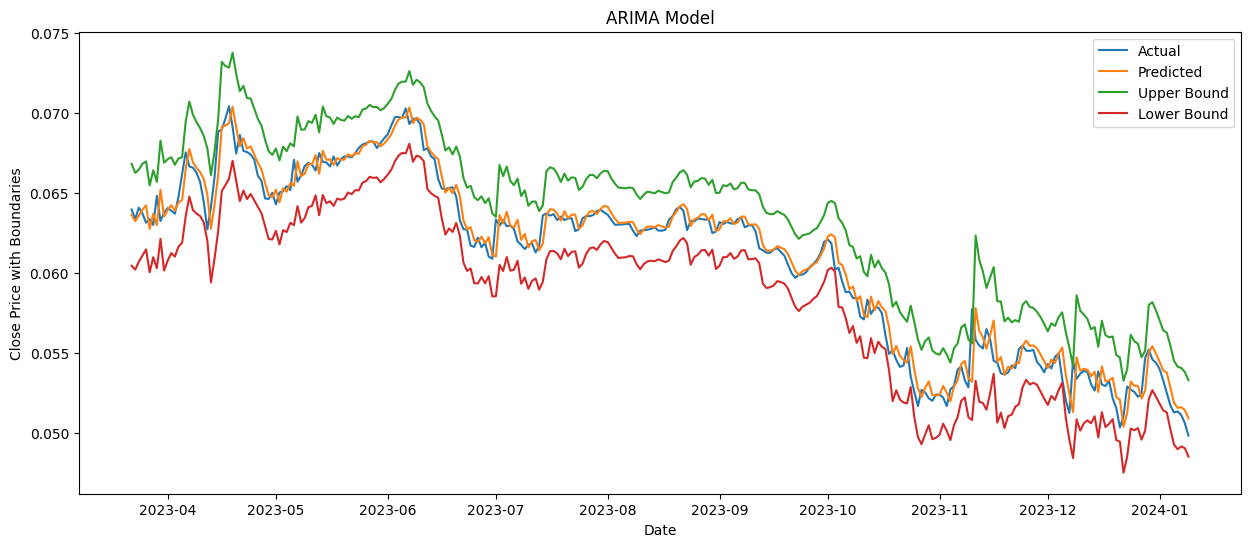

RMSE: 0.000842677655916912


In [156]:
predictions_series = pd.Series(predictions, index=test_date)
test_returns = full_df.iloc[-test_size:]


# Plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(test_returns, label='Actual')
plt.plot(predictions_series, label='Predicted')
plt.plot(predictions_series + 1.96 * pd.Series(predictions_volatility, index=test_date), label='Upper Bound')
plt.plot(predictions_series - 1.96 * pd.Series(predictions_volatility, index=test_date), label='Lower Bound')
plt.title('ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Close Price with Boundaries')
plt.legend()
plt.show()


# RMSE
rmse = np.sqrt(metrics.mean_squared_error(test_returns, predictions_series))
print(f"RMSE: {rmse}")

In [157]:

new_df = pd.concat([new_df, predictions_series], axis=1)

In [145]:
new_df = full_df.loc[(full_df.index >= pd.to_datetime('2021-01-06')) & (full_df.index <= pd.to_datetime('2023-05-21'))]
new_df.to_csv('../data/df_returns.csv', sep=';')

In [147]:
# Resuts Analysis
print(f"RMSE: {rmse}")
print(f"MAE: {metrics.mean_absolute_error(test_returns, predictions_series)}")
print(f"R2: {metrics.r2_score(test_returns, predictions_series)}")


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print(f"MAPE: {mape(test_returns, predictions_series)}")

def times_outside_boundary(y_true, y_pred, volatility):
    # Calculate boundary
    volatility = np.array(volatility)
    boundary = 1.96 * volatility
    
    # if y_true above or below boundary return 1 else 0
    return np.where((y_true > y_pred + boundary) | (y_true < y_pred - boundary), 1, 0).sum()

print(f"Times outside boundary: {times_outside_boundary(test_returns, predictions_series, predictions_volatility)} out of {len(test_returns)}")

RMSE: 0.0008509571547549106
MAE: 0.0005990373385855836
R2: 0.9751969876400138
MAPE: 1.007704351794587
Times outside boundary: 2 out of 294


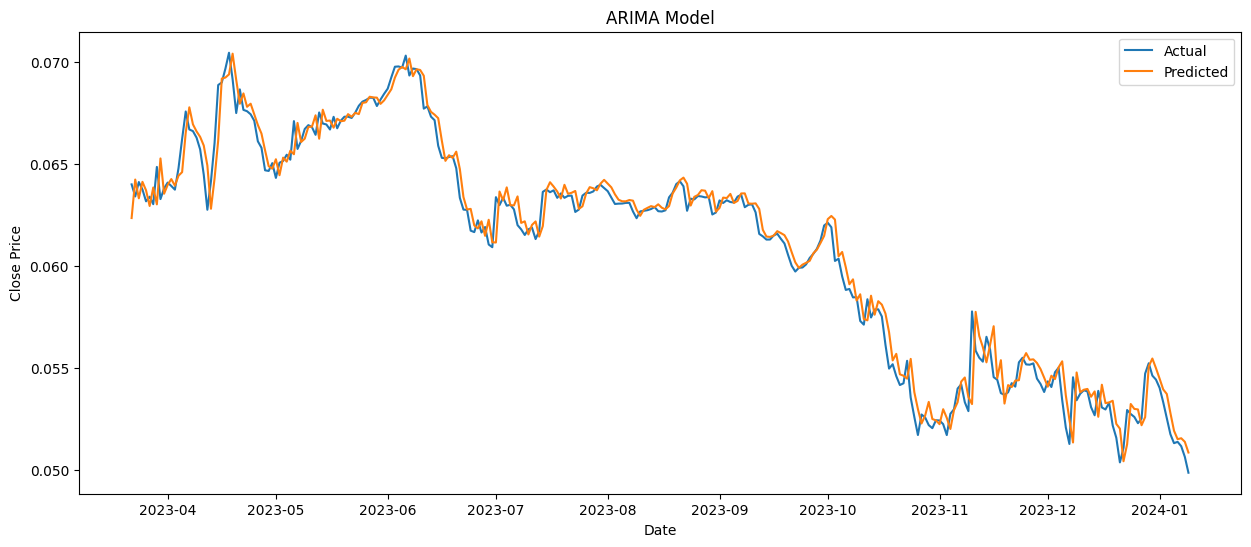

In [148]:
test_returns.sort_index(inplace=True)
predictions_series.sort_index(inplace=True)

# Plot without the bounds
plt.figure(figsize=(15, 6))
plt.plot(test_returns, label='Actual')
plt.plot(predictions_series, label='Predicted')
plt.title('ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


C:\Users\yinki\AppData\Local\Temp\ipykernel_10228\4041778377.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df_test_period['Predicted Close (WBTC)'] = predictions_series


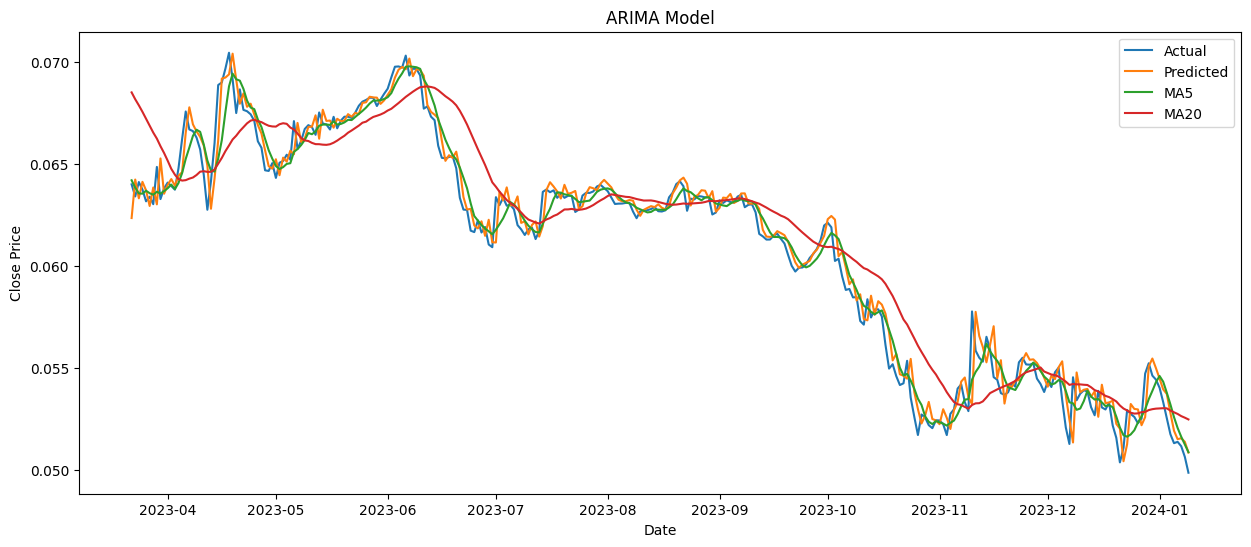

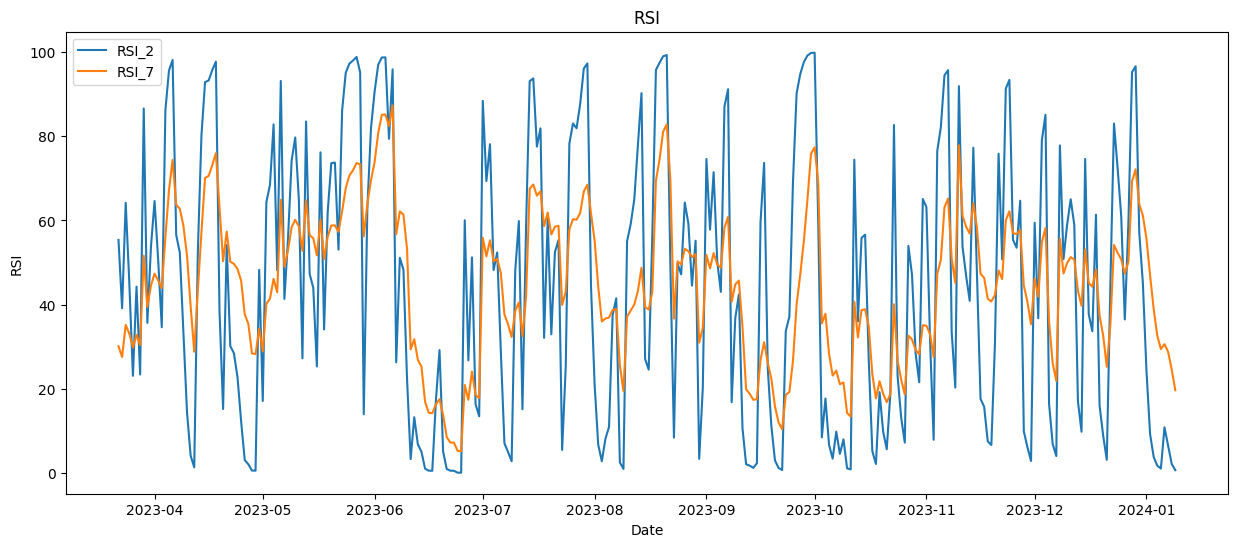

In [149]:
# Add in MA5, MA20, 
import pandas_ta as ta

full_df_indicators = pd.DataFrame(full_df)
#print(full_df_indicators)
full_df_indicators = full_df_indicators.assign(
    MA5 = full_df_indicators['Close (WBTC)'].rolling(window=5).mean(),
    MA20 = full_df_indicators['Close (WBTC)'].rolling(window=20).mean(),
    RSI_2 = ta.rsi(full_df_indicators['Close (WBTC)'], length=2),
    RSI_7 = ta.rsi(full_df_indicators['Close (WBTC)'], length=7)
    
)
full_df_indicators

y_train = full_df.iloc[: -(test_size - i)]

first_date_test = predictions_series.index[0]

full_df_test_period = full_df_indicators.iloc[full_df_indicators.index >= first_date_test]
full_df_test_period['Predicted Close (WBTC)'] = predictions_series
full_df_test_period


# Plot without the bounds + MA5, MA20, RSI
plt.figure(figsize=(15, 6))
plt.plot(full_df_test_period['Close (WBTC)'], label='Actual')
plt.plot(full_df_test_period['Predicted Close (WBTC)'], label='Predicted')
plt.plot(full_df_test_period['MA5'], label='MA5')
plt.plot(full_df_test_period['MA20'], label='MA20')
plt.title('ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot RSI
plt.figure(figsize=(15, 6))
plt.plot(full_df_test_period['RSI_2'], label='RSI_2')
plt.plot(full_df_test_period['RSI_7'], label='RSI_7')
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()



In [150]:
# Monte Carlo Simulation ARIMA-GARCH Walk Foward Generation

# Create empty list to hold predictions
predictions_volatility = []
predictions = []
test_date = []



def arima_garch_walk_forward(start_price, end_price, arima_order, garch_order, dataset, test_data, num_simulations, expected_end=0.05269):
    time_horizon = len(test_data) - 1  # Adjust the time horizon based on the dataset size
    simulations = np.zeros((num_simulations, time_horizon + 1))
    simulations[:, 0] = start_price
    #print(simulations)
    #dataset = dataset.values
    test_dates = test_data.index
    s = 0
    while s < num_simulations:
        np.random.seed(random.randint(0, 10000))
        current_dataset = dataset.copy()
        predictions = []
        predictions.append(start_price)

        for i in range(1, time_horizon + 1):
            # Use the observed data up to the current point for training
            train_data = current_dataset
            
            # Fit ARIMA model
            arima_model = sm.tsa.ARIMA(train_data, order=arima_order)
            arima_fit = arima_model.fit()

            # Generate GARCH innovations
            garch_innovations = arima_fit.resid

            # Fit GARCH model
            garch_model = arch_model(garch_innovations, vol='Garch', p=garch_order[0], q=garch_order[1])
            garch_fit = garch_model.fit(disp='off', show_warning=False)

            # Make a one-step forecast using the ARIMA-GARCH model
            arima_forecast = arima_fit.forecast(steps=1).values[0]
            garch_volatility = garch_fit.conditional_volatility[-1]
            
            #print(f'Predicted Close (WBTC): {arima_forecast}, Predicted Volatility: {garch_volatility}')
            
            #print(simulations[s, i- 1])
            path = arima_forecast + garch_volatility * np.random.normal(0, 1)

            # Update the simulations array
            #print(simulations[s, i], path)
            #simulations[s, i] = path
            
            # Update the dataset
            new_row = pd.Series([path], index=[test_dates[i]])
            current_dataset = current_dataset.append(new_row)
            predictions.append(path)
            
        
        # Check last price within 10% of expected end price else re run
        #print(simulations[s, -1])
        #if simulations[s, -1] < expected_end * 0.9 or simulations[s, -1] > expected_end * 1.1:
        #    print(f"Re-running simulation {s}") 

        #else:
        #    simulations[s, :] = predictions 
        #    print(predictions)
        #    s += 1
        #    print(f"Simulation {s} complete")
        simulations[s, :] = predictions
        s += 1
        print(f"Simulation {s} complete")

    return simulations

# Example parameters
start_price = 0.06730264
end_price = 120.0
arima_order = (1, 0, 5)  # ARIMA(p, d, q)
garch_order = (1, 1)     # GARCH(p, q)
num_simulations = 10

#print(np.asarray(df_returns.values))

simulations = arima_garch_walk_forward(start_price, end_price, arima_order, garch_order, df_returns, test_returns, num_simulations)



C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.517e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\yinki\AppData\Local\Temp\ipykernel_10228\3788665718.py:54: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current_dataset = current_dataset.append(new_row)
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: 

KeyboardInterrupt: 

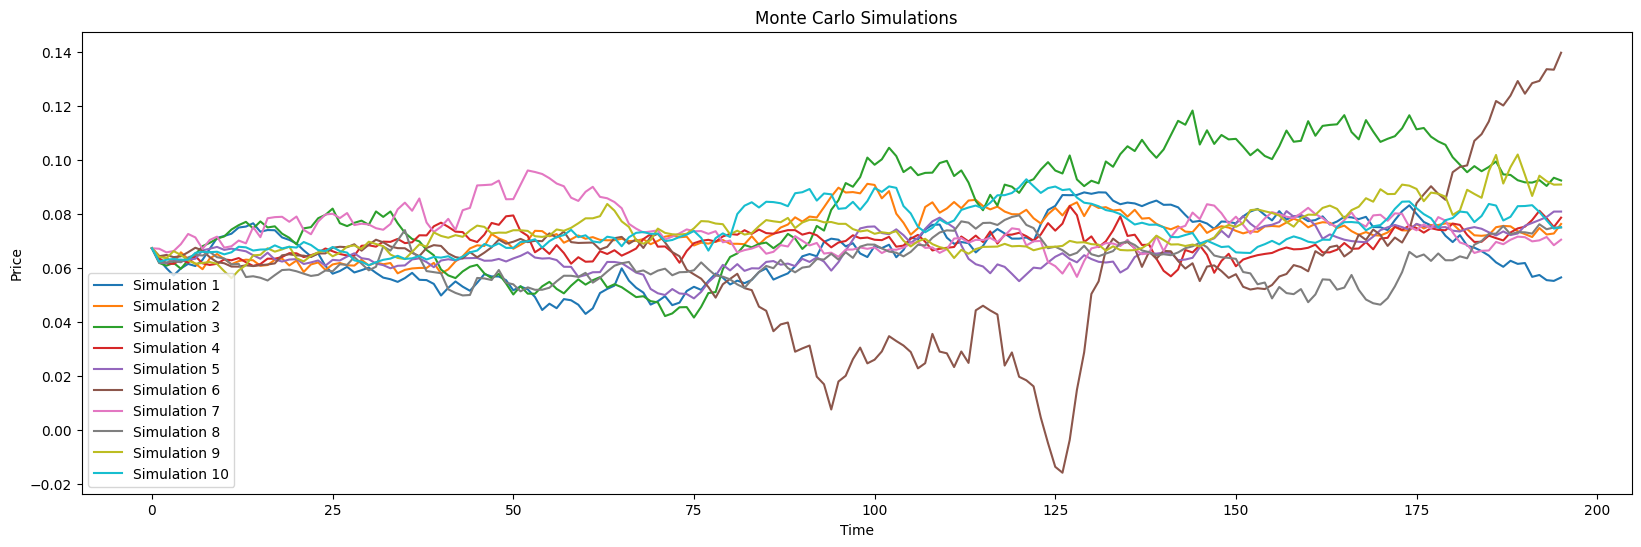

In [ ]:
# Plot the simulations
plt.figure(figsize=(20, 6))
plt.plot(simulations.T)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(['Simulation ' + str(i + 1) for i in range(num_simulations)])
plt.title('Monte Carlo Simulations')
plt.show()



In [ ]:
simulations_df = pd.DataFrame(simulations.T, index=test_returns.index)
simulations_df.columns = ['Simulation ' + str(i + 1) for i in range(num_simulations)]
simulations_df.to_csv('../data/simulations_50.csv', index=True)
simulations_df





# Expected Price at the end is 0.05269 , acceptable ranges are [0.05269 - 0.05269 * 0.05, 0.05269 + 0.05269 * 0.05]

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10
Date,,,,,,,,,,
2023-06-28,0.067303,0.067303,0.067303,0.067303,0.067303,0.067303,0.067303,0.067303,0.067303,0.067303
2023-06-29,0.063046,0.064470,0.061867,0.063611,0.061968,0.064357,0.067127,0.062033,0.064104,0.062331
2023-06-30,0.059919,0.063776,0.060852,0.061735,0.061863,0.064821,0.065782,0.062028,0.063615,0.063044
2023-07-01,0.057217,0.061878,0.061880,0.061510,0.062626,0.064012,0.066273,0.062483,0.066243,0.063346
2023-07-02,0.059829,0.065805,0.059715,0.063034,0.062429,0.064328,0.068839,0.062115,0.064835,0.063049
...,...,...,...,...,...,...,...,...,...,...
2024-01-05,0.056710,0.071474,0.091642,0.077757,0.076695,0.128504,0.069859,0.072734,0.086686,0.083263
2024-01-06,0.057399,0.074814,0.092554,0.081202,0.077743,0.129332,0.070235,0.076199,0.094192,0.080733
2024-01-07,0.055490,0.072417,0.090407,0.078428,0.078891,0.133666,0.071488,0.074349,0.092171,0.077689


In [ ]:
# Make rolling forecasted volatility
from scipy.stats import norm

forecasted_volatilities = garch_model.forecast(horizon=test_returns.shape[0], reindex=True).variance.iloc[-1, :] ** 0.5
# Plot the simulations
start_volatility, end_volatility = forecasted_volatilities.iloc[0], forecasted_volatilities.iloc[-1]



# Lower and Upper Bounds Optimization 

def generate_bounds(start_volatility, end_volatility, start_price, expected_end=0.139772, confidence=0.95):
    # Calculate the lower and upper bounds
    z_stat = norm.ppf(1 - (1 - confidence) / 2)
    #print(z_stat)
    if start_price > expected_end:
        lower_bound = expected_end - end_volatility * z_stat
        upper_bound = start_price + start_volatility * z_stat
        
    else:
        lower_bound = start_price - start_volatility * z_stat
        upper_bound = expected_end + end_volatility * z_stat
    return lower_bound, upper_bound

lower_bound, upper_bound = generate_bounds(start_volatility, end_volatility, start_price)
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")


Lower bound: 0.06411350058296572, Upper bound: 0.14730439526886635


In [ ]:
simulations_df['Simulation 6']

Date
2023-06-28    0.067303
2023-06-29    0.064357
2023-06-30    0.064821
2023-07-01    0.064012
2023-07-02    0.064328
                ...   
2024-01-05    0.128504
2024-01-06    0.129332
2024-01-07    0.133666
2024-01-08    0.133482
2024-01-09    0.139772
Freq: D, Name: Simulation 6, Length: 196, dtype: float64

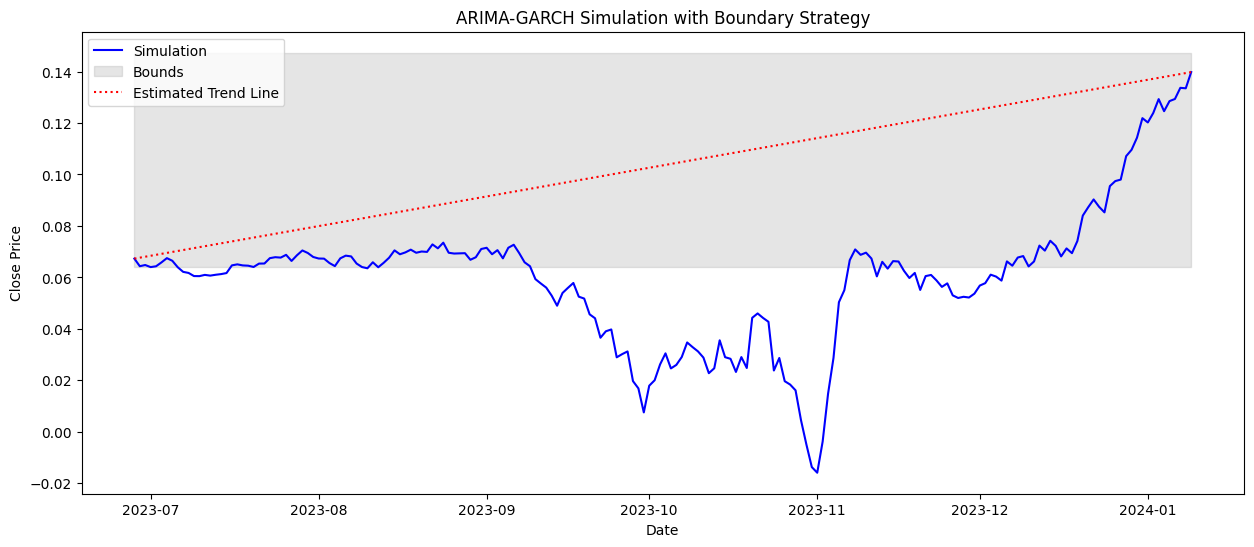

In [ ]:
# Get Simulation where last value closest to expected end price
expected_end = 0.05269
final_df = simulations_df.iloc[-1, :]
final_df = final_df[(final_df > expected_end * 0.95) & (final_df < expected_end * 1.05)]


# Plot Simulation 6 Lower bound: 0.04177481929059751, Upper bound: 0.07653292116574624
plt.figure(figsize=(15, 6))
plt.plot(simulations_df['Simulation 6'], label='Simulation', color='blue')

# Plotting the upper and lower bounds
plt.fill_between(simulations_df.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='Bounds')
plt.plot(simulations_df.index[[0, -1]], [0.067303, 0.139772], linestyle='dotted', color='red', label='Estimated Trend Line')
plt.title('ARIMA-GARCH Simulation with Boundary Strategy')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

            Close (WBTC)
Date                    
2023-06-28      0.067303
2023-06-29      0.064357
2023-06-30      0.064821
2023-07-01      0.064012
2023-07-02      0.064328
...                  ...
2024-01-05      0.128504
2024-01-06      0.129332
2024-01-07      0.133666
2024-01-08      0.133482
2024-01-09      0.139772

[196 rows x 1 columns]


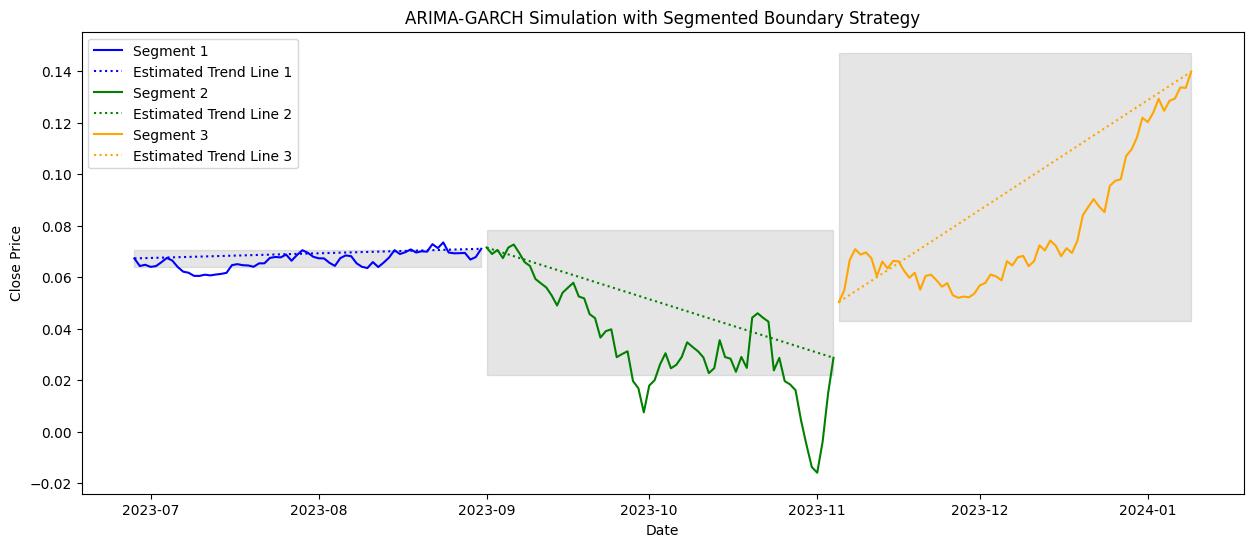

In [ ]:
# Simulations 3 Boundaries
# Your forecasted volatility series (replace this with your actual data)
# Replace with your actual values

# Your expected end
expected_end = 0.05269
current_simulation = pd.DataFrame(simulations_df['Simulation 6']).rename(columns={'Simulation 6': 'Close (WBTC)'})
print(current_simulation)

# Splitting the data into three segments based on time
split_date1 = current_simulation.index[len(current_simulation) // 3]
split_date2 = current_simulation.index[len(current_simulation) // 3 * 2]

segment1 = current_simulation[current_simulation.index < split_date1]
segment2 = current_simulation[(current_simulation.index >= split_date1) & (current_simulation.index < split_date2)]
segment3 = current_simulation[current_simulation.index >= split_date2]

# Plotting the three segments
plt.figure(figsize=(15, 6))

# Segment 1
lower_bound1 = segment1['Close (WBTC)'].iloc[0] - 1.96 * forecasted_volatilities[current_simulation.index.get_loc(segment1.index[0])]
upper_bound1 = segment1['Close (WBTC)'].iloc[0] + 1.96 * forecasted_volatilities[current_simulation.index.get_loc(segment1.index[0])]
plt.plot(segment1.index, segment1['Close (WBTC)'], label='Segment 1', color='blue')
plt.fill_between(segment1.index, lower_bound1, upper_bound1, color='gray', alpha=0.2)
plt.plot(segment1.index[[0, -1]], [segment1['Close (WBTC)'].iloc[0], segment1['Close (WBTC)'].iloc[-1]], linestyle='dotted', color='blue', label='Estimated Trend Line 1')


# Segment 2
lower_bound2 = segment2['Close (WBTC)'].iloc[0] + 1.96 * forecasted_volatilities[current_simulation.index.get_loc(segment2.index[0])]
upper_bound2 = segment2['Close (WBTC)'].iloc[-1] -  1.96 * forecasted_volatilities[current_simulation.index.get_loc(segment2.index[0])]
plt.plot(segment2.index, segment2['Close (WBTC)'], label='Segment 2', color='green')
plt.fill_between(segment2.index, lower_bound2, upper_bound2, color='gray', alpha=0.2)
plt.plot(segment2.index[[0, -1]], [segment2['Close (WBTC)'].iloc[0], segment2['Close (WBTC)'].iloc[-1]], linestyle='dotted', color='green', label='Estimated Trend Line 2')


# Segment 3
lower_bound3 = segment3['Close (WBTC)'].iloc[0] - 1.96 * forecasted_volatilities[current_simulation.index.get_loc(segment3.index[0])]
upper_bound3 = segment3['Close (WBTC)'].iloc[-1] + 1.96 * forecasted_volatilities[current_simulation.index.get_loc(segment3.index[0])]
plt.plot(segment3.index, segment3['Close (WBTC)'], label='Segment 3', color='orange')
plt.fill_between(segment3.index, lower_bound3, upper_bound3, color='gray', alpha=0.2)
plt.plot(segment3.index[[0, -1]], [segment3['Close (WBTC)'].iloc[0], segment3['Close (WBTC)'].iloc[-1]], linestyle='dotted', color='orange', label='Estimated Trend Line 3')


plt.title('ARIMA-GARCH Simulation with Segmented Boundary Strategy')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
# Fees Calculations
import math

def calculate_fees_daily(feeTier, volume_24h, deltaL, total_liquidity):
    return feeTier * volume_24h * (deltaL / (total_liquidity + deltaL))

def calculate_deltaL(deposit_amount_usd, P, Pl, Pu, price_usd_y, price_usd_x):
    return deposit_amount_usd / ((math.sqrt(P) - math.sqrt(Pl)) * price_usd_y + (1 / math.sqrt(P) - 1 / math.sqrt(Pu)) * price_usd_x)

def calculate_deltaX(deltaL, P, Pu):
    return deltaL * (1 / math.sqrt(P) - 1 / math.sqrt(Pu))

def calculate_deltaY(deltaL, P, Pl):
    return deltaL * (math.sqrt(P) - math.sqrt(Pl))


def fetch_tick_day_datas(start_date_unix_timestamp=1684800000, tick_idx_gte=100, tick_idx_lte=200):
    graphql_endpoint = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
    
    
    pool_id = "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed"
    
    graphql_query = f"""
    {{
      tickDayDatas(
        where: {{
          date_in: [{start_date_unix_timestamp}],
          pool_in: ["{pool_id}"],
        
        }},
        skip: 0,
        first: 1000,
        orderBy: date,
        orderDirection: asc
      ) {{
        id
        date
        pool {{
          id
          token0 {{
            id
            symbol
          }}
          token1 {{
            id
            symbol
          }}
        }}
        tick {{
          id
          tickIdx
        }}
        liquidityGross
        liquidityNet
        volumeToken0
        volumeToken1
        volumeUSD
        feesUSD
        feeGrowthOutside0X128
        feeGrowthOutside1X128
      }}
}}
    """
  
    headers = {
        'Content-Type': 'application/json',
    }

    data = {
        'query': graphql_query,
    }

    response = requests.post(graphql_endpoint, headers=headers, json=data)

    if response.status_code == 200 and response.json().get('data'):
        output = response.json()
        #print(output)
        df = pd.json_normalize(output['data']['tickDayDatas'])
        df['tick.tickIdx'] = df['tick.tickIdx'].astype(int)
        df = df.sort_values(by=['tick.tickIdx'])
        return df
    else:
        print(f"Error: {response.status_code}")
        print(response.text)  # Print the response content for debugging
        return None



In [ ]:
import tools
import requests

# Get current tick at start of simulation
start_date = test_returns.index[0]
start_tick = int(df.loc[start_date]['Tick'].replace(',', ''))


def generate_lower_tick(start_tick, current_price, lower_bound, tick_spacing=60):
    print(f"Curent price: {current_price}, Lower bound: {lower_bound}")
    current_tick = 1.0001 ** (current_price)
    print(f"Curent tick: {current_tick}, Start tick: {start_tick}")
    lower_tick = math.log(lower_bound)/math.log(1.0001)
    
    
    return lower_tick

#lower_tick = generate_lower_tick(start_tick, start_price, lower_bound)

#print(f"Start tick: {start_tick}", f"Lower tick: {lower_tick}")
ticks_data = fetch_tick_day_datas(start_date_unix_timestamp=1684800000, tick_idx_gte=100, tick_idx_lte=200)

def calculate_total_liquidity(ticks_data, il, ic):
    # Sum of liquidity Net of ticks where tickidx is between il and ic
    total_liquidity = ticks_data[(ticks_data['tick.tickIdx'] >= il) & (ticks_data['tick.tickIdx'] <= ic)]['liquidityNet'].sum()
    return total_liquidity

#total_liquidity = calculate_total_liquidity(ticks_data, lower_tick, start_tick)
#print(f"Total liquidity: {total_liquidity}")


#ticks_data


# Proxy Numbers from PoolFish with Most Active Price = 0.05269, Lower bound: 0.04177481929059751, Upper bound: 0.07653292116574624
# From PoolFish
Yearly_APR = 0.0458
Daily_APR = Yearly_APR / 365
feeTier = 0.3
Initial_Deposit = 1000000
fees_daily = Daily_APR * Initial_Deposit



In [ ]:
# Do calculations based on simulations, given a specific bound and simulations, calculate the fees expected payoff for each simulation
def calculate_payoff(simulations, lower_bound, upper_bound, Initial_Deposit, Daily_APR):
    
    fees_daily = Daily_APR * Initial_Deposit
    payoff = 0
    results = {
        'Simulation': [],
        'Fees Generated': [],
    }
    # Based on Simulations, calculate the fees expected payoff for each simulation, payoff = fees_daily * days_inside_bound
    for i in range(simulations.shape[0]):
        #print(f"Simulation {i + 1}")
        current_simulation = simulations[i, :]
        fees_generated = 0
        for j in range(len(current_simulation)):
            if current_simulation[j] > lower_bound and current_simulation[j] < upper_bound:
                fees_generated += fees_daily
                
        results['Simulation'].append(i + 1)
        results['Fees Generated'].append(fees_generated)
        
        
    results_df = pd.DataFrame(results)
    print('Mean Fees Generated: ', results_df['Fees Generated'].mean())
    print('Max Fees Generated: ', results_df['Fees Generated'].max())
    print('Min Fees Generated: ', results_df['Fees Generated'].min())
    print('Std Fees Generated: ', results_df['Fees Generated'].std())
    
    
    return results_df, results_df['Fees Generated'].mean(), results_df['Fees Generated'].std()


expected_payoff_df, mean_fees, std_fees  = calculate_payoff(simulations, lower_bound, upper_bound, Initial_Deposit, Daily_APR)
print(f"Expected payoff: {mean_fees}, Std: {std_fees}")


Mean Fees Generated:  12723.61643835618
Max Fees Generated:  21080.547945205515
Min Fees Generated:  7528.767123287677
Std Fees Generated:  4333.918105189674
Expected payoff: 12723.61643835618, Std: 4333.918105189674
